# EDA (Explority Data Analysis)


In [1]:
import kagglehub
kagglehub.login()

Kaggle credentials set.
Kaggle credentials successfully validated.


In [2]:
ieee_fraud_detection_path = kagglehub.competition_download('ieee-fraud-detection')

print('Data source import complete.')

100%|██████████| 118M/118M [00:00<00:00, 209MB/s]

Extracting files...


Data source import complete.


### Global imports

In [3]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns',100)
pd.set_option('display.max_rows', 500)

### Dataset Description

Continuous Variables

TransactionDT: timedelta from a given reference datetime (not an actual timestamp)

TransactionAMT: transaction payment amount in USD

dist: May be the distance from addresses

C1-C14: counting, such as how many addresses are found to be associated with the payment card, etc. The actual meaning is masked.

D1-D15: timedelta, such as days between previous transaction, etc.

V1 - V339: Vesta engineered rich features, including ranking, counting, and other entity relations.

id_01 - id_11(In identity table)

Categorical Variables

ProductCD: product code, the product for each transaction

card1 - card6: payment card information, such as card type, card category, issue bank, country, etc.

addr1, addr2: both are for purchaser, addr1 as billing region, addr2 as billing country

Pemaildomain, Remaildomain: purchaser and recipient email domain

M1 - M9: match, such as names on card and address, etc.

From Identity Table:

Variables in this table are identity information – network connection information (IP, ISP, Proxy, etc) and digital signature (UA/browser/os/version, etc) associated with transactions. They're collected by Vesta’s fraud protection system and digital security partners.

id12 - id38, DeviceType, DeviceInfo

### Modules

In [18]:
""" Visulization Module """

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Tuple


def plot_merge_results(train_df: pd.DataFrame, train_identity: pd.DataFrame,
                       test_df: pd.DataFrame, test_identity: pd.DataFrame) -> None:
    """
    Plots two pie charts side by side showing the proportion of matched vs. unmatched
    transactions for both the training and test sets.
    """

    def get_match_counts(df: pd.DataFrame, identity_df: pd.DataFrame) -> Tuple[int, int]:
        identity_ids = set(identity_df['TransactionID'])
        matched_count = df['TransactionID'].isin(identity_ids).sum()
        unmatched_count = (~df['TransactionID'].isin(identity_ids)).sum()
        return matched_count, unmatched_count

    # Get counts for train and test
    train_matched, train_unmatched = get_match_counts(train_df, train_identity)
    test_matched, test_unmatched = get_match_counts(test_df, test_identity)

    # Data for pie charts
    labels_train = [f"Matched: {train_matched}", f"Unmatched: {train_unmatched}"]
    labels_test = [f"Matched: {test_matched}", f"Unmatched: {test_unmatched}"]
    sizes_train = [train_matched, train_unmatched]
    sizes_test = [test_matched, test_unmatched]
    colors = ['mediumaquamarine', 'salmon']

    # Plot side-by-side pie charts
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    axes[0].pie(sizes_train, labels=labels_train, autopct='%1.1f%%', colors=colors, startangle=140)
    axes[0].set_title("Train Set: Matched vs Unmatched Transactions")

    axes[1].pie(sizes_test, labels=labels_test, autopct='%1.1f%%', colors=colors, startangle=140)
    axes[1].set_title("Test Set: Matched vs Unmatched Transactions")

    plt.tight_layout()
    plt.show()


def plot_missing_values(train_df: pd.DataFrame, test_df: pd.DataFrame):
    """
    Plots a grouped bar chart comparing the percentage of missing values in Train vs Test,
    with clear labels centered above each bar and additional padding for readability.
    """
    def calculate_missing_values(df: pd.DataFrame) -> List[float]:
        """Calculate the percentage of features with missing values exceeding certain thresholds."""
        thresholds = [0, 25, 50, 75, 90, 99]
        return [(len(df.isnull().sum()[df.isnull().sum() / df.shape[0] * 100 > i]) / df.shape[1]) * 100 for i in thresholds]

    train_percentages = calculate_missing_values(train_df)
    test_percentages = calculate_missing_values(test_df)

    # Define bins (thresholds) for missing values
    bins = [">0%", ">25%", ">50%", ">75%", ">90%", ">99%"]

    plt.figure(figsize=(8, 6))
    width = 0.4

    x = range(len(bins))

    plt.bar([p - width/2 for p in x], train_percentages, width, color='slateblue', alpha=0.7, label="Train")
    plt.bar([p + width/2 for p in x], test_percentages, width, color='coral', alpha=0.7, label="Test")

    # Formatting
    plt.xlabel("Missing Value Percentage Bins")
    plt.ylabel("Percentage of Features")
    plt.title("Distribution of Features with Missing Values: Train vs Test")
    plt.xticks(x, bins)
    plt.ylim(0, 105)
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.legend()

    for i, val in enumerate(train_percentages):
        plt.text(i - width/2, val + 4, f"{val:.1f}%", ha='center', fontsize=9, color='black')

    for i, val in enumerate(test_percentages):
        plt.text(i + width/2, val + 4, f"{val:.1f}%", ha='center', fontsize=9, color='black')

    plt.show()


def analyze_missing_values(df: pd.DataFrame, top_n: int=None, bottom_n: int=None, sort_by="percent") -> pd.DataFrame:
    """
    Generates a summary of missing values, unique counts, and data types for each column.
    Allows sorting by missing percentage and returns top or bottom N columns.
    """
    summary = pd.DataFrame(df.dtypes, columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]
    summary['Missing(%)'] = df.isnull().sum().values / train.shape[0]*100
    summary['Uniques'] = df.nunique().values

    if sort_by == "percent":
        summary_df = summary.sort_values(by='Missing(%)', ascending=False)
    else:
        summary_df = summary.sort_values(by='Uniques', ascending=False)

    if top_n:
        return summary_df.head(top_n)
    elif bottom_n:
        return summary_df.tail(bottom_n)
    else:
        return summary_df



def plot_fraud_distribution(df: pd.DataFrame, fraud_column='isFraud'):
    """
    Plots the distribution of fraud vs. non-fraud transactions as a bar chart with a legend matching bar colors.
    """
    plt.figure(figsize=(6, 5))

    fraud_distribution = df[fraud_column].value_counts(normalize=True) * 100
    colors = ['mediumseagreen', 'salmon']
    barplot = sns.barplot(x=fraud_distribution.index, y=fraud_distribution.values, palette=colors)

    for p in barplot.patches:
        barplot.annotate(f"{p.get_height():.2f}%",
                         (p.get_x() + p.get_width() / 2., p.get_height()),
                         ha='center', va='center',
                         xytext=(0, 5), textcoords='offset points')

    plt.title("Fraud Transactions Distribution")
    plt.xlabel("Is Fraud?")
    plt.ylabel("Percentage")
    plt.xticks([0, 1], labels=["Legit (0)", "Fraud (1)"])
    plt.ylim(0, 105)

    from matplotlib.patches import Patch
    legend_labels = [Patch(color=colors[0], label="Legit (0)"), Patch(color=colors[1], label="Fraud (1)")]
    plt.legend(handles=legend_labels, loc="upper right")

    plt.show()

def plot_time_span(train: pd.DataFrame, test: pd.DataFrame):
    """
    Plots a bar chart comparing the time spans of the train and test datasets,
    including the gap between them.
    """
    train_span = (train['TransactionDT'].max() - train['TransactionDT'].min()) / (3600 * 24)
    test_span = (test['TransactionDT'].max() - test['TransactionDT'].min()) / (3600 * 24)
    total_span = (test['TransactionDT'].max() - train['TransactionDT'].min()) / (3600 * 24)
    gap_span = (test['TransactionDT'].min() - train['TransactionDT'].max()) / (3600 * 24)

    categories = ['Train Span', 'Test Span', 'Total Span', 'Gap Between Train & Test']
    values = [train_span, test_span, total_span, gap_span]

    plt.figure(figsize=(8, 5))
    bars = plt.barh(categories, values, color=['blue', 'red', 'green', 'orange'])

    for bar in bars:
        plt.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2,
                 f"{bar.get_width():.2f} days", va='center', fontsize=10)

    plt.xlabel("Time Span (Days)")
    plt.title("Time Span Comparison of Train and Test Datasets")
    plt.grid(axis='x', linestyle='--', alpha=0.6)
    plt.show()


def plot_transaction_distribution(train: pd.DataFrame, test: pd.DataFrame, bins: int, train_color="blue", test_color="orange"):
    """
    Plots the distribution of TransactionDT for both train and test datasets.
    """
    plt.figure(figsize=(12, 5))

    sns.histplot(train['TransactionDT'], bins=bins, color=train_color, alpha=0.6, label="Train", kde=False)
    sns.histplot(test['TransactionDT'], bins=bins, color=test_color, alpha=0.6, label="Test", kde=False)

    plt.legend()
    plt.xlabel("TransactionDT (Time)")
    plt.ylabel("Frequency")
    plt.title(f"Distribution of TransactionDT (bins = {bins})")
    plt.grid(axis='y', linestyle='--', alpha=0.6)

    plt.show()


def plot_fraud_transaction_distribution(data: pd.DataFrame, day_col="day", fraud_col="isFraud"):
    """
    Plots the percentage distribution of fraudulent and non-fraudulent transactions by day.
    """
    # Compute percentage of transactions per fraud category
    day_distribution = (
        data.groupby(fraud_col)[day_col]
        .value_counts(normalize=True)
        .mul(100)
        .rename("percentage")
        .reset_index()
        .sort_values(day_col)
    )

    # Plot settings
    plt.figure(figsize=(10, 6))
    barplot = sns.barplot(
        x=day_col,
        y="percentage",
        hue=fraud_col,
        data=day_distribution,
        palette="pastel"
    )

    # Labels and title
    plt.xlabel("Day of Week")
    plt.ylabel("Percentage of Transaction Frequency")
    plt.title("Percentage of Fraudulent and Legit Transactions Frequency")

    # Add annotations
    for p in barplot.patches:
        barplot.annotate(
            f"{p.get_height():.2f}",
            (p.get_x() + p.get_width() / 2, p.get_height()),
            ha="center",
            va="center",
            xytext=(0, 5),
            textcoords="offset points"
        )

    # Show legend and plot
    plt.legend(title="Fraud Status")
    plt.show()


def plot_hourly_fraud_trend(df: pd.DataFrame):
    """
    Plots the hourly trend of fraudulent transactions along with total transaction volume.
    """

    plt.figure(figsize=(10, 6))

    # Line plot for fraud rate over hours
    plt.plot(
        df.groupby("hour")["isFraud"].mean(),
        color='hotpink', linewidth=2, label="Fraud Rate"
    )

    # Create secondary axis for histogram
    ax = plt.gca()
    ax2 = ax.twinx()
    ax2.hist(df["hour"], alpha=0.4, bins=24, color="yellowgreen", label="Transaction Count")

    # Labels and title
    ax.set_xlabel("Transaction Hour")
    ax.set_ylabel("Fraudulent Transaction Rate")
    ax2.set_ylabel("Total Transactions")
    plt.title("Transaction Volume (Green Histogram) vs. Fraud Rate (Pink Line)")

    # X-axis ticks
    plt.xticks(np.arange(1, 25, 1))

    # Show the plot
    plt.show()



def detect_outliers_iqr(data: pd.DataFrame, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 3 * IQR
    upper_bound = Q3 + 3 * IQR

    lower_outliers = data[data[column] < lower_bound]
    upper_outliers = data[data[column] > upper_bound]

    print(f"Number of lower outliers (< Q1 - 3*IQR): {len(lower_outliers)}")
    print(f"Number of upper outliers (> Q3 + 3*IQR): {len(upper_outliers)}")

    return lower_outliers, upper_outliers

def describeFraudLegit(datatrain: pd.DataFrame , datatest: pd.DataFrame, feature):
    stats = ['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max']

    # Create an empty DataFrame
    d = pd.DataFrame(columns=[feature, 'Train', 'Train_Fraud', 'Train_Legit', 'Test'])
    d[feature] = stats + ['unique', 'NaN', 'NaN_share']

    # Compute statistics for each dataset
    d.loc[:7, 'Train'] = datatrain[feature].describe()[stats].values
    d.loc[:7, 'Train_Fraud'] = datatrain[datatrain['isFraud'] == 1][feature].describe()[stats].values
    d.loc[:7, 'Train_Legit'] = datatrain[datatrain['isFraud'] == 0][feature].describe()[stats].values
    d.loc[:7, 'Test'] = datatest[feature].describe()[stats].values

    # Unique value counts
    d.loc[8, ['Train', 'Train_Fraud', 'Train_Legit', 'Test']] = [
        datatrain[feature].nunique(),
        datatrain[datatrain['isFraud'] == 1][feature].nunique(),
        datatrain[datatrain['isFraud'] == 0][feature].nunique(),
        datatest[feature].nunique()
    ]

    # NaN counts
    d.loc[9, ['Train', 'Train_Fraud', 'Train_Legit', 'Test']] = [
        datatrain[feature].isna().sum(),
        datatrain[datatrain['isFraud'] == 1][feature].isna().sum(),
        datatrain[datatrain['isFraud'] == 0][feature].isna().sum(),
        datatest[feature].isna().sum()
    ]

    # NaN share
    d.loc[10, ['Train', 'Train_Fraud', 'Train_Legit', 'Test']] = [
        datatrain[feature].isna().mean(),
        datatrain[datatrain['isFraud'] == 1][feature].isna().mean(),
        datatrain[datatrain['isFraud'] == 0][feature].isna().mean(),
        datatest[feature].isna().mean()
    ]

    return d


def plot_transaction_scatter(train: pd.DataFrame, test: pd.DataFrame):
    plt.figure(figsize=(14,6))

    # Train dataset plot
    plt.subplot(1,2,1)
    sns.scatterplot(x="TransactionDT", y="TransactionAmt", hue="isFraud", data=train,  alpha=0.7, palette={0: "blue", 1: "red"})
    plt.title('Train: Transaction Time vs Amount (Fraud Highlighted)')
    plt.xlabel("TransactionDT")
    plt.ylabel("TransactionAmt")
    plt.grid(True)

    # Test dataset plot
    plt.subplot(1,2,2)
    sns.scatterplot(x="TransactionDT", y="TransactionAmt", data=test,  alpha=0.7, color="green")
    plt.title('Test: Transaction Time vs Amount')
    plt.xlabel("TransactionDT")
    plt.ylabel("TransactionAmt")
    plt.grid(True)

    plt.tight_layout()
    plt.show()

def plot_transaction_amount_distribution(train: pd.DataFrame, test: pd.DataFrame):
    plt.figure(figsize=(17,6))

    # Train dataset plot
    plt.subplot(1,2,1)
    sns.kdeplot(train[train['isFraud']==0]['TransactionAmt'], color='blue', shade=True)
    sns.kdeplot(train[train['isFraud']==1]['TransactionAmt'], color='red', shade=True)

    plt.ylabel('Probability Density')
    plt.legend(['Legit Transactions', 'Fraudulent Transactions'])
    plt.title('Train Set: Transaction Amount Distribution')

    # Test dataset plot
    plt.subplot(1,2,2)
    sns.kdeplot(test['TransactionAmt'], color='green', shade=True)

    plt.ylabel('Probability Density')
    plt.title('Test Set: Transaction Amount Distribution')

    # Global title
    plt.suptitle('Comparison of Transaction Amount Distributions', fontsize=13)

    plt.show()


def plot_log_transaction_distribution(train: pd.DataFrame, test: pd.DataFrame):
    # Compute log mean and std
    log_std = train['LogTransactionAmt'].std()
    log_mean = train['LogTransactionAmt'].mean()
    lower_bound = log_mean - log_std

    plt.figure(figsize=(12,6))

    # Train dataset plot
    plt.subplot(1,2,1)
    sns.kdeplot(train[train['isFraud']==0]['LogTransactionAmt'], color='blue', shade=True)
    sns.kdeplot(train[train['isFraud']==1]['LogTransactionAmt'], color='red', shade=True)

    plt.xticks(np.arange(-2, 10, 1))
    plt.ylabel('Probability Density')
    plt.legend(['Legit Transactions', 'Fraudulent Transactions'])
    plt.title('Train Set: Log-Transformed Transaction Amount')
    plt.grid(True)

    # Test dataset plot
    plt.subplot(1,2,2)
    sns.kdeplot(test['LogTransactionAmt'], color='green', shade=True)

    plt.xticks(np.arange(-4, 10, 1))
    plt.ylabel('Probability Density')
    plt.title('Test Set: Log-Transformed Transaction Amount')
    plt.grid(True)

    # Global title
    plt.suptitle('Distribution of Log-Transformed Transaction Amounts', fontsize=12)

    plt.show()



def plot_productcd_distribution(data: pd.DataFrame):
    plt.figure(figsize=(6,6))

    # Compute fraud and legit percentage for each ProductCD
    productcd_dist = (
        data.groupby(['isFraud'])['ProductCD']
        .value_counts(normalize=True)
        .rename('percentage')
        .mul(100)
        .reset_index()
        .sort_values('ProductCD')
    )

    sns.barplot(x="ProductCD", y="percentage", hue="isFraud", data=productcd_dist, palette="muted")

    plt.title('Fraud vs Legit Transactions by ProductCD')
    plt.ylabel('Percentage (%)')
    plt.xlabel('ProductCD')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()


def plot_card_distribution(train: pd.DataFrame, test: pd.DataFrame, card_column: str):
    # Ensure the column is numeric
    train[card_column] = pd.to_numeric(train[card_column], errors='coerce')
    test[card_column] = pd.to_numeric(test[card_column], errors='coerce')

    plt.figure(figsize=(12,6))

    # Train dataset plot
    plt.subplot(1,2,1)
    sns.kdeplot(train[train['isFraud']==0][card_column].dropna(), color='blue', shade=True)
    sns.kdeplot(train[train['isFraud']==1][card_column].dropna(), color='red', shade=True)

    plt.ylabel('Probability Density')
    plt.legend(['Legit Transactions', 'Fraudulent Transactions'])
    plt.suptitle(f'{card_column} Distribution', fontsize=12)
    plt.title('Train')

    # Test dataset plot
    plt.subplot(1,2,2)
    sns.kdeplot(test[card_column].dropna(), color='green', shade=True)
    plt.title('Test')

    plt.show()


def apply_card_to_fraud_high_prob(row):
    if row == np.nan:
        return row
    else:
        if float(row) > 160:
            return 'True'
        else:
            return 'False'

def plot_card4_distribution(data: pd.DataFrame):
    """Plots the distribution of fraud vs legit transactions across card types."""
    plt.figure(figsize=(12,6))

    card4_distribution = (
        data.dropna(subset=['card4'])
        .groupby(['isFraud'])['card4']
        .value_counts(normalize=True)
        .rename('percentage')
        .mul(100)
        .reset_index()
        .sort_values('card4')
    )

    sns.barplot(x="card4", y="percentage", hue="isFraud", data=card4_distribution, palette="muted")

    plt.title('Fraud vs Legit Transaction Distribution by Card Type')
    plt.ylabel('Percentage (%)')
    plt.xlabel('Card Type')
    plt.grid(axis='y', linestyle='--', alpha=0.6)

    plt.show()

def plot_card6_distribution(train: pd.DataFrame, test: pd.DataFrame):
    """Plots the distribution of fraudulent vs legit transactions for card6 in train and test datasets."""
    plt.figure(figsize=(12,6))

    plt.subplot(1,2,1)
    train_card6 = (
        train.dropna(subset=['card6'])
        .groupby(['isFraud'])['card6']
        .value_counts(normalize=True)
        .rename('percentage')
        .mul(100)
        .reset_index()
        .sort_values('card6')
    )

    sns.barplot(x="card6", y="percentage", hue="isFraud", data=train_card6, palette="muted")
    plt.title('Card6 Distribution in Train')
    plt.ylabel('Percentage (%)')
    plt.xlabel('Card6 Type')
    plt.grid(axis='y', linestyle='--', alpha=0.6)

    plt.subplot(1,2,2)
    test_card6 = (
        test.dropna(subset=['card6'])['card6']
        .value_counts(normalize=True)
        .mul(100)
        .rename('percentage')
        .reset_index()
        .rename(columns={'index': 'card6'})
    )

    sns.barplot(x="card6", y="percentage", data=test_card6, palette="muted")
    plt.xlabel('Card6 Type')
    plt.ylabel('Percentage (%)')
    plt.title('Card6 Distribution in Test')
    plt.grid(axis='y', linestyle='--', alpha=0.6)


    plt.suptitle('Fraud vs Legit Transaction Frequency by Card6 Type', fontsize=12)

    plt.show()



def replacetodebit(row):
    if row==np.nan:
        return row
    if row=='debit or credit' or row=='charge card':
        return 'debit'
    else:
        return row

    train['card6'] = train['card6'].apply(replacetodebit)
    test['card6'] = test['card6'].apply(replacetodebit)


def plot_card6_distribution(train: pd.DataFrame, test: pd.DataFrame):
    """Plots the distribution of fraudulent vs legit transactions for card6 in train and test datasets."""
    plt.figure(figsize=(9,4))

    plt.subplot(1,2,1)
    train_card6 = (
        train.dropna(subset=['card6'])
        .groupby(['isFraud'])['card6']
        .value_counts(normalize=True)
        .rename('percentage')
        .mul(100)
        .reset_index()
        .sort_values('card6')
    )

    sns.barplot(x="card6", y="percentage", hue="isFraud", data=train_card6, palette="muted")
    plt.title('Card6 Distribution in Train')
    plt.ylabel('Percentage (%)')
    plt.xlabel('Card6 Type')
    plt.grid(axis='y', linestyle='--', alpha=0.6)

    plt.subplot(1,2,2)
    test_card6 = (
        test.dropna(subset=['card6'])['card6']
        .value_counts(normalize=True)
        .mul(100)
        .rename('percentage')
        .reset_index()
        .rename(columns={'index': 'card6'})  # Rename 'index' to 'card6' to avoid ValueError
    )

    sns.barplot(x="card6", y="percentage", data=test_card6, palette="muted")
    plt.xlabel('Card6 Type')
    plt.ylabel('Percentage (%)')
    plt.title('Card6 Distribution in Test')
    plt.grid(axis='y', linestyle='--', alpha=0.6)

    plt.suptitle('Fraud vs Legit Transaction Frequency by Card6 Type', fontsize=12)

    plt.tight_layout()
    plt.show()


def plot_purchaser_region_distribution(train: pd.DataFrame):
    """Plots the distribution of purchaser regions (addr1) for fraud and legit transactions."""
    plt.figure(figsize=(11,6))

    sns.kdeplot(train.loc[(train['isFraud'] == 0) & train['addr1'].notna(), 'addr1'], color='blue', shade=True)
    sns.kdeplot(train.loc[(train['isFraud'] == 1) & train['addr1'].notna(), 'addr1'], color='red', shade=True)

    plt.legend(['Legit Transactions', 'Fraudulent Transactions'])
    plt.xticks(range(0, 600, 20))
    plt.ylabel('Density')
    plt.xlabel('Purchaser Region (addr1)')
    plt.title('Distribution of Purchaser Regions in Train Set')
    plt.grid(axis='y', linestyle='--', alpha=0.6)

    plt.show()

def plot_purchaser_billing_country_distribution(train: pd.DataFrame):
    """Plots the distribution of purchaser billing countries (addr2) for fraud and legit transactions."""
    plt.figure(figsize=(18,6))

    sns.kdeplot(train.loc[(train['isFraud'] == 0) & train['addr2'].notna(), 'addr2'], color='blue', shade=True)
    sns.kdeplot(train.loc[(train['isFraud'] == 1) & train['addr2'].notna(), 'addr2'], color='red', shade=True)

    plt.legend(['Legit Transactions', 'Fraudulent Transactions'])
    plt.ylabel('Density')
    plt.xlabel('Purchaser Billing Country (addr2)')
    plt.xticks(range(0, 102, 2))
    plt.title('Distribution of Purchaser Billing Countries in Train Set')
    plt.grid(axis='y', linestyle='--', alpha=0.6)

    plt.show()


def plot_distance_distribution(train: pd.DataFrame):
    """Plots the distribution of dist1 (distance feature) for fraud and legit transactions."""
    plt.figure(figsize=(16,6))

    sns.kdeplot(train.loc[(train['isFraud'] == 0) & train['dist1'].notna(), 'dist1'], color='blue', shade=True)
    sns.kdeplot(train.loc[(train['isFraud'] == 1) & train['dist1'].notna(), 'dist1'], color='red', shade=True)

    plt.legend(['Legit Transactions', 'Fraudulent Transactions'])
    plt.xticks(range(0, 10000, 500))
    plt.ylabel('Density')
    plt.xlabel('Distance (dist1)')
    plt.title('Distribution of Dist1 in Train Set')
    plt.grid(axis='y', linestyle='--', alpha=0.6)

    plt.show()


def plot_transactionamt_vs_distance(train: pd.DataFrame):
    """Plots Transaction Amount vs Distance (dist1), separated by fraud and legit transactions."""
    plt.figure(figsize=(10,6))

    sns.scatterplot(
        x="TransactionAmt",
        y="dist1",
        hue="isFraud",
        data=train.dropna(subset=['dist1']),
        alpha=0.8,
        hue_order=[0,1],
        palette={0: "blue", 1: "red"}
    )

    plt.title('Transaction Amount vs Distance (dist1) - Separated by Fraud and Legit')
    plt.xlabel('Transaction Amount')
    plt.ylabel('Distance from Address (dist1)')
    plt.grid(True)

    plt.show()

def plot_transactionamt_vs_distance2(train: pd.DataFrame):
    """Plots Transaction Amount vs Distance2 (dist2), separated by fraud and legit transactions."""
    plt.figure(figsize=(10,6))

    sns.scatterplot(
        x="TransactionAmt",
        y="dist2",
        hue="isFraud",
        data=train.dropna(subset=['dist2']),
        alpha=0.8,
        hue_order=[0,1],
        palette={0: "blue", 1: "red"}
    )

    plt.title('Transaction Amount vs Distance2 - seprated Fraud and Legit Transactions')
    plt.xlabel('Transaction Amount')
    plt.ylabel('Distance from Address (dist2)')
    plt.grid(True)

    plt.show()


def plot_email_domain_distribution(train: pd.DataFrame):

    """Plots the distribution of fraud vs legit transactions by email domains (P_emaildomain & R_emaildomain)."""
    plt.figure(figsize=(16,8))

    # Subplot 1: P_emaildomain distribution
    plt.subplot(1,2,1)
    train_P_email = (
        train.dropna(subset=['P_emaildomain'])
        .groupby(['isFraud'])['P_emaildomain']
        .value_counts(normalize=True)
        .rename('percentage')
        .mul(100)
        .reset_index()
    )

    sns.barplot(x="P_emaildomain", y="percentage", hue="isFraud", data=train_P_email, palette="pastel")
    plt.xticks(rotation=90)
    plt.xlabel('Purchaser Email Domain')
    plt.ylabel('Percentage (%)')
    plt.title('Fraud vs Legit Transactions by Purchaser Email Domain')
    plt.grid(axis='y', linestyle='--', alpha=0.6)

    # Subplot 2: R_emaildomain distribution
    plt.subplot(1,2,2)
    train_R_email = (
        train.dropna(subset=['R_emaildomain'])
        .groupby(['isFraud'])['R_emaildomain']
        .value_counts(normalize=True)
        .mul(100)
        .rename('percentage')
        .reset_index()
    )

    sns.barplot(x="R_emaildomain", y="percentage", hue="isFraud", data=train_R_email, palette="pastel")
    plt.xticks(rotation=90)
    plt.xlabel('Recipient Email Domain')
    plt.ylabel('Percentage (%)')
    plt.title('Fraud vs Legit Transactions by Recipient Email Domain')
    plt.grid(axis='y', linestyle='--', alpha=0.6)

    # Adjust layout and add title
    plt.suptitle('Fraud vs Legit Distribution Across Email Domains', fontsize=18)
    plt.tight_layout()

    plt.show()


def process_email_domains(train: pd.DataFrame, test: pd.DataFrame):
    """
    Clean and categorize email domains.
    """
    # Process email domains for both train and test sets
    for df in [train, test]:
        # Process purchaser email domains (P_emaildomain)
        # Group Google domains
        df.loc[df['P_emaildomain'].isin(['gmail.com', 'gmail']), 'P_emaildomain'] = 'Google'

        # Group Yahoo domains
        df.loc[df['P_emaildomain'].isin([
            'yahoo.com', 'yahoo.com.mx', 'yahoo.co.uk', 'yahoo.co.jp',
            'yahoo.de', 'yahoo.fr', 'yahoo.es'
        ]), 'P_emaildomain'] = 'Yahoo'

        # Group Microsoft domains
        df.loc[df['P_emaildomain'].isin([
            'hotmail.com', 'outlook.com', 'msn.com', 'live.com.mx', 'hotmail.es',
            'hotmail.co.uk', 'hotmail.de', 'outlook.es', 'live.com', 'live.fr',
            'hotmail.fr'
        ]), 'P_emaildomain'] = 'Microsoft'

        # Group rare domains
        df.loc[df.P_emaildomain.isin(
            df.P_emaildomain.value_counts()[df.P_emaildomain.value_counts() <= 500].index
        ), 'P_emaildomain'] = "Others"

        # Fill missing values
        df.P_emaildomain.fillna("unknown", inplace=True)

        # Process receiver email domains (R_emaildomain)
        # Group Google domains
        df.loc[df['R_emaildomain'].isin(['gmail.com', 'gmail']), 'R_emaildomain'] = 'Google'

        # Group Yahoo domains
        df.loc[df['R_emaildomain'].isin([
            'yahoo.com', 'yahoo.com.mx', 'yahoo.co.uk', 'yahoo.co.jp',
            'yahoo.de', 'yahoo.fr', 'yahoo.es'
        ]), 'R_emaildomain'] = 'Yahoo'

        # Group Microsoft domains
        df.loc[df['R_emaildomain'].isin([
            'hotmail.com', 'outlook.com', 'msn.com', 'live.com.mx', 'hotmail.es',
            'hotmail.co.uk', 'hotmail.de', 'outlook.es', 'live.com', 'live.fr',
            'hotmail.fr'
        ]), 'R_emaildomain'] = 'Microsoft'

        # Group rare domains
        df.loc[df.R_emaildomain.isin(
            df.R_emaildomain.value_counts()[df.R_emaildomain.value_counts() <= 300].index
        ), 'R_emaildomain'] = "Others"

        # Fill missing values
        df.R_emaildomain.fillna("unknown", inplace=True)

    return train, test

def plot_email_domain_distribution(train: pd.DataFrame):
    """Plots the distribution of fraud vs legit transactions by email domains (P_emaildomain & R_emaildomain)."""
    plt.figure(figsize=(16,8))

    # Subplot 1: P_emaildomain distribution
    plt.subplot(1,2,1)
    train_P_email = (
        train.dropna(subset=['P_emaildomain'])
        .groupby(['isFraud'])['P_emaildomain']
        .value_counts(normalize=True)
        .rename('percentage')
        .mul(100)
        .reset_index()
    )

    sns.barplot(x="P_emaildomain", y="percentage", hue="isFraud", data=train_P_email, palette="pastel")
    plt.xticks(rotation=90)
    plt.xlabel('Purchaser Email Domain')
    plt.ylabel('Percentage (%)')
    plt.title('Fraud vs Legit Transactions by Purchaser Email Domain')
    plt.grid(axis='y', linestyle='--', alpha=0.6)

    # Subplot 2: R_emaildomain distribution
    plt.subplot(1,2,2)
    train_R_email = (
        train.dropna(subset=['R_emaildomain'])
        .groupby(['isFraud'])['R_emaildomain']
        .value_counts(normalize=True)
        .mul(100)
        .rename('percentage')
        .reset_index()
    )

    sns.barplot(x="R_emaildomain", y="percentage", hue="isFraud", data=train_R_email, palette="pastel")
    plt.xticks(rotation=90)
    plt.xlabel('Recipient Email Domain')
    plt.ylabel('Percentage (%)')
    plt.title('Fraud vs Legit Transactions by Recipient Email Domain')
    plt.grid(axis='y', linestyle='--', alpha=0.6)

    # Adjust layout and add title
    plt.suptitle('Fraud vs Legit Distribution Across Email Domains', fontsize=18)
    plt.tight_layout()

    plt.show()

def create_card_features(train: pd.DataFrame, test: pd.DataFrame) -> Tuple[pd.DataFrame, ...]:
    """
    Create features based on card information.
    """

    def apply_card_to_fraud_high_prob(row):
        if row == np.nan:
            return row
        else:
            if float(row) > 160:
                return 'True'
            else:
                return 'False'

    train['prob_card3'] = train['card3'].apply(apply_card_to_fraud_high_prob)
    test['prob_card3'] = test['card3'].apply(apply_card_to_fraud_high_prob)

    return train, test


def plot_continuous_features_over_time(train: pd.DataFrame, test: pd.DataFrame):
    """
    Plots scatterplots of continuous variables (C1-C14) over TransactionDT,
    separating fraud and legit transactions.

    """
    plt.figure(figsize=(20, 50))

    continuous_vars = [f'C{i}' for i in range(1, 15)]

    for i, col in enumerate(continuous_vars, start=1):
        # Train dataset plot
        plt.subplot(7, 4, i * 2 - 1)
        sns.scatterplot(
            x="TransactionDT",
            y=col,
            hue="isFraud",
            data=train.dropna(subset=[col]),
            palette={0: "blue", 1: "red"},  # Blue = Legit, Red = Fraud
            alpha=0.7
        )
        plt.title(f'Train - {col}')

        # Test dataset plot
        plt.subplot(7, 4, i * 2)
        sns.scatterplot(
            x="TransactionDT",
            y=col,
            data=test.dropna(subset=[col]),
            color="green",
            alpha=0.7
        )
        plt.title(f'Test - {col}')

    plt.tight_layout()  # Adjust layout to prevent overlapping
    plt.show()


def remove_outliers(train: pd.DataFrame):
    """
    Remove outliers from numerical C features.

    Parameters:
    train (pandas.DataFrame): Training dataset

    Returns:
    pandas.DataFrame: Training dataset with outliers removed
    """
    train.drop(train[train.C1 > 3000].index, axis=0, inplace=True)
    train.drop(train[train.C2 > 3000].index, axis=0, inplace=True)
    train.drop(train[train.C7 > 1400].index, axis=0, inplace=True)
    train.drop(train[train.C4 > 1400].index, axis=0, inplace=True)
    train.drop(train[train.C6 > 1400].index, axis=0, inplace=True)
    train.drop(train[train.C7 > 1400].index, axis=0, inplace=True)
    train.drop(train[train.C8 > 1000].index, axis=0, inplace=True)
    train.drop(train[train.C10 > 1000].index, axis=0, inplace=True)
    train.drop(train[train.C11 > 2000].index, axis=0, inplace=True)
    train.drop(train[train.C12 > 2000].index, axis=0, inplace=True)
    train.drop(train[train.C13 > 1200].index, axis=0, inplace=True)
    train.drop(train[train.C14 > 800].index, axis=0, inplace=True)
    return train


def describe_continuous_features(train: pd.DataFrame, test: pd.DataFrame):
    """
    Computes descriptive statistics for continuous features (C1-C14) in the train and test datasets.
    """
    col_names = [f'C{i}' for i in range(1, 15)]  # Generate column names C1-C14
    desc_names = [f'C{i}_desc' for i in range(1, 15)]  # Generate descriptive column names

    # Generate descriptive statistics for each C variable
    descriptions = [describeFraudLegit(train, test, col) for col in col_names]

    # Concatenate results into a single DataFrame
    return pd.concat(descriptions, axis=1, keys=desc_names)


def describe_timedelta_features(train: pd.DataFrame, test: pd.DataFrame):
    """
    Computes descriptive statistics for timedelta features (D1-D15) in the train and test datasets.
    """
    # Define the column names and the corresponding descriptive statistics column names
    col_names = [f'D{i}' for i in range(1, 16)]
    desc_names = [f'D{i}_desc' for i in range(1, 16)]

    # Compute descriptive statistics for each D variable
    descriptions = [describeFraudLegit(train, test, col) for col in col_names]

    # Concatenate all the descriptions into a single DataFrame with appropriate column names
    return pd.concat(descriptions, axis=1, keys=desc_names)


def plot_timedelta_features_over_time(train: pd.DataFrame, test: pd.DataFrame):
    """
    Plots scatterplots of timedelta features (D1-D15) over TransactionDT,
    separating fraud and legit transactions.
    """
    plt.figure(figsize=(20, 50))

    timedelta_vars = [f'D{i}' for i in range(1, 16)]

    for i, col in enumerate(timedelta_vars, start=1):
        # Train dataset plot
        plt.subplot(8, 4, i * 2 - 1)
        sns.scatterplot(
            x="TransactionDT",
            y=col,
            hue="isFraud",
            data=train.dropna(subset=[col]),
            palette={0: "blue", 1: "red"},  # Blue = Legit, Red = Fraud
            alpha=0.7
        )
        plt.title(f'Train - {col}')

        # Test dataset plot
        plt.subplot(8, 4, i * 2)
        sns.scatterplot(
            x="TransactionDT",
            y=col,
            data=test.dropna(subset=[col]),
            color="green",
            alpha=0.7
        )
        plt.title(f'Test - {col}')

    plt.tight_layout()  # Adjust layout to prevent overlapping
    plt.show()

def plot_categorical_m_features(train: pd.DataFrame):
    """
    Plots the percentage distribution of fraud and legit transactions
    for categorical M features (M1-M9).
    """
    plt.figure(figsize=(18, 18))

    m_features = [f'M{i}' for i in range(1, 10)]

    for i, col in enumerate(m_features, start=1):
        # Compute percentage distribution of fraud and legit for each M feature
        m_distribution = (
            train.dropna(subset=[col])  # Handle missing values
            .groupby(['isFraud'])[col]
            .value_counts(normalize=True)
            .rename('percentage')
            .mul(100)
            .reset_index()
            .sort_values(col)
        )

        # Create subplots
        plt.subplot(3, 3, i)
        sns.barplot(x=col, y="percentage", hue="isFraud", data=m_distribution, palette="pastel")
        plt.title(f'Distribution of {col}')
        plt.ylabel('Percentage (%)')

    plt.tight_layout()  # Prevent overlapping subplots
    plt.show()


def plot_id_feature_distribution(train: pd.DataFrame):
    """
    Plots the percentage distribution of fraud and legit transactions
    for selected ID features in the dataset.
    """
    plt.figure(figsize=(30, 40))

    # Define selected ID features
    id_features = [f'id_{x}' for x in ['03', '04', 12, 14, 15, 16, 18, 23, 24, 27,
                                       28, 29, 32, 34, 35, 36, 37, 38]]

    for i, col in enumerate(id_features, start=1):
        # Compute fraud and legit percentage distribution for each ID feature
        id_distribution = (
            train.dropna(subset=[col])  # Handle missing values
            .groupby(['isFraud'])[col]
            .value_counts(normalize=True)
            .rename('percentage')
            .mul(100)
            .reset_index()
            .sort_values(col)
        )

        # Create subplots
        plt.subplot(6, 3, i)
        sns.barplot(x=col, y="percentage", hue="isFraud", data=id_distribution, palette="pastel")
        plt.title(f'Distribution of {col}')
        plt.ylabel('Percentage (%)')

    plt.tight_layout()  # Prevent subplot overlap
    plt.show()


def plot_device_type_distribution(train: pd.DataFrame, test: pd.DataFrame):
    """
    Plots the percentage distribution of fraud and legit transactions
    for different DeviceTypes in the train and test datasets.
    """
    plt.figure(figsize=(12, 6))

    # Train dataset: DeviceType distribution
    plt.subplot(1, 2, 1)
    train_device_type = (
        train.dropna(subset=['DeviceType'])
        .groupby(['isFraud'])['DeviceType']
        .value_counts(normalize=True)
        .rename('percentage')
        .mul(100)
        .reset_index()
        .sort_values('DeviceType')
    )

    sns.barplot(x="DeviceType", y="percentage", hue="isFraud", data=train_device_type, palette="pastel")
    plt.title('Train: DeviceType Distribution')
    plt.ylabel('Percentage (%)')
    plt.xlabel('Device Type')
    plt.grid(axis='y', linestyle='--', alpha=0.6)

    # Test dataset: DeviceType distribution
    plt.subplot(1, 2, 2)
    test_device_type = (
        test.dropna(subset=['DeviceType'])['DeviceType']
        .value_counts(normalize=True)
        .mul(100)
        .rename('percentage')
        .reset_index()
        .rename(columns={'index': 'DeviceType'})  # Fix KeyError by renaming column
    )

    sns.barplot(x="DeviceType", y="percentage", data=test_device_type, palette="pastel")
    plt.xlabel('Device Type')
    plt.ylabel('Percentage (%)')
    plt.title('Test: DeviceType Distribution')
    plt.grid(axis='y', linestyle='--', alpha=0.6)

    # Adjust layout
    plt.tight_layout()
    plt.show()



def plot_missing_specific_columns(train_df: pd.DataFrame, test_df: pd.DataFrame, columns: list):

    missing_train = train_df[columns].isnull().sum()
    missing_test = test_df[columns].isnull().sum()

    plt.figure(figsize=(16, 6))
    bar_width = 0.4
    positions = range(len(columns))

    plt.bar(
        [p - bar_width / 2 for p in positions],
        missing_train.values,
        width=bar_width,
        label='Train missing values'
    )
    plt.bar(
        [p + bar_width / 2 for p in positions],
        missing_test.values,
        width=bar_width,
        label='Test missing values'
    )

    plt.xticks(positions, columns, rotation=45)
    plt.ylabel('Number of missing values')
    plt.title('Missing Values in Train and Test datasets')
    plt.legend()
    plt.tight_layout()
    plt.show()

### Dataset Size

In [ ]:
from data_loader import load_raw_data, merge_datasets, get_data_dtypes

dtypes_train_transaction, dtypes_train_identity, dtypes_test_transaction, dtypes_test_identity = get_data_dtypes()

# Load raw data
train_transaction, train_identity, test_transaction, test_identity = load_raw_data(
    dtypes_train_transaction, dtypes_train_identity, dtypes_test_transaction, dtypes_test_identity, ieee_fraud_detection_path
)

# Merge datasets
train, test = merge_datasets(train_transaction, train_identity, test_transaction, test_identity)

In [8]:
train_transaction.shape, train_identity.shape, test_transaction.shape, test_identity.shape

((590540, 394), (144233, 41), (506691, 393), (141907, 41))

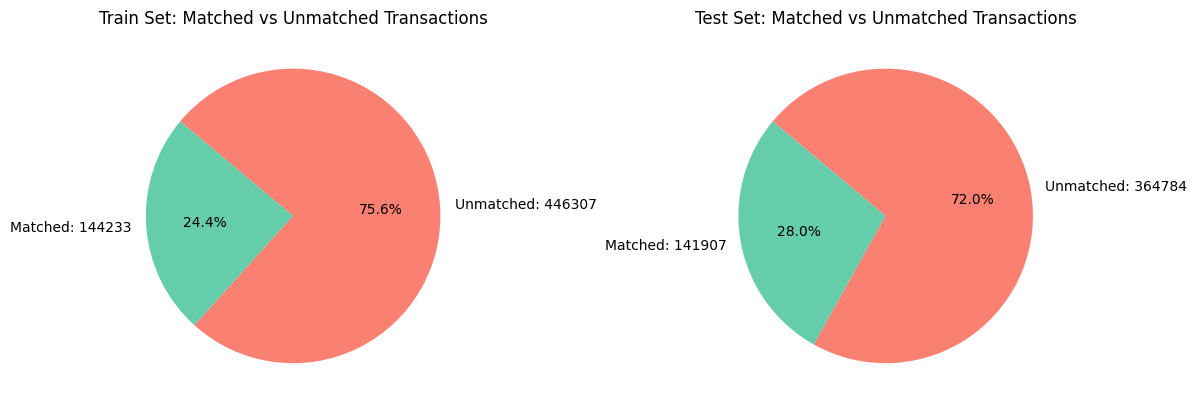

In [19]:
plot_merge_results(train_transaction, train_identity, test_transaction, test_identity)

We can see only 24-28% matched trainsaction id's between transaction to identity tables, leading to sparse identitiy features.

In [20]:
train.shape, test.shape

((590540, 434), (506691, 433))

In [ ]:
train.head()

TransactionID  isFraud  TransactionDT  TransactionAmt ProductCD  card1  \
0        2987000        0          86400            68.5         W  13926   
1        2987001        0          86401            29.0         W   2755   
2        2987002        0          86469            59.0         W   4663   
3        2987003        0          86499            50.0         W  18132   
4        2987004        0          86506            50.0         H   4497   

   card2  card3       card4  card5   card6  addr1  addr2  dist1  dist2  \
0    NaN  150.0    discover  142.0  credit  315.0   87.0   19.0    NaN   
1  404.0  150.0  mastercard  102.0  credit  325.0   87.0    NaN    NaN   
2  490.0  150.0        visa  166.0   debit  330.0   87.0  287.0    NaN   
3  567.0  150.0  mastercard  117.0   debit  476.0   87.0    NaN    NaN   
4  514.0  150.0  mastercard  102.0  credit  420.0   87.0    NaN    NaN   

  P_emaildomain R_emaildomain   C1   C2   C3   C4   C5   C6   C7   C8   C9  \
0           NaN           NaN  1.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0   
1     gmail.com           NaN  1.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0   
2   outlook.com           NaN  1.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0   
3     yahoo.com           NaN  2.0  5.0  0.0  0.0  0.0  4.0  0.0  0.0  1.0   
4     gmail.com           NaN  1.0  1.0  0.0  0.0  0.0  1.0  0.0  1.0  0.0   

   C10  C11  C12   C13  C14     D1     D2    D3    D4   D5  D6  D7  D8  D9  \
0  0.0  2.0  0.0   1.0  1.0   14.0    NaN  13.0   NaN  NaN NaN NaN NaN NaN   
1  0.0  1.0  0.0   1.0  1.0    0.0    NaN   NaN   0.0  NaN NaN NaN NaN NaN   
2  0.0  1.0  0.0   1.0  1.0    0.0    NaN   NaN   0.0  NaN NaN NaN NaN NaN   
3  0.0  1.0  0.0  25.0  1.0  112.0  112.0   0.0  94.0  0.0 NaN NaN NaN NaN   
4  1.0  1.0  0.0   1.0  1.0    0.0    NaN   NaN   NaN  NaN NaN NaN NaN NaN   

    D10    D11  D12  D13  D14    D15   M1   M2   M3   M4  ... V330 V331 V332  \
0  13.0   13.0  NaN  NaN  NaN    0.0    T    T    T   M2  ...  NaN  NaN  NaN   
1   0.0    NaN  NaN  NaN  NaN    0.0  NaN  NaN  NaN   M0  ...  NaN  NaN  NaN   
2   0.0  315.0  NaN  NaN  NaN  315.0    T    T    T   M0  ...  NaN  NaN  NaN   
3  84.0    NaN  NaN  NaN  NaN  111.0  NaN  NaN  NaN   M0  ...  NaN  NaN  NaN   
4   NaN    NaN  NaN  NaN  NaN    NaN  NaN  NaN  NaN  NaN  ...  0.0  0.0  0.0   

  V333 V334  V335  V336  V337  V338  V339  id_01    id_02  id_03  id_04  \
0  NaN  NaN   NaN   NaN   NaN   NaN   NaN    NaN      NaN    NaN    NaN   
1  NaN  NaN   NaN   NaN   NaN   NaN   NaN    NaN      NaN    NaN    NaN   
2  NaN  NaN   NaN   NaN   NaN   NaN   NaN    NaN      NaN    NaN    NaN   
3  NaN  NaN   NaN   NaN   NaN   NaN   NaN    NaN      NaN    NaN    NaN   
4  0.0  0.0   0.0   0.0   0.0   0.0   0.0    0.0  70787.0    NaN    NaN   

   id_05  id_06  id_07  id_08  id_09  id_10  id_11     id_12  id_13  id_14  \
0    NaN    NaN    NaN    NaN    NaN    NaN    NaN       NaN    NaN    NaN   
1    NaN    NaN    NaN    NaN    NaN    NaN    NaN       NaN    NaN    NaN   
2    NaN    NaN    NaN    NaN    NaN    NaN    NaN       NaN    NaN    NaN   
3    NaN    NaN    NaN    NaN    NaN    NaN    NaN       NaN    NaN    NaN   
4    NaN    NaN    NaN    NaN    NaN    NaN  100.0  NotFound    NaN -480.0   

   id_15     id_16  id_17  id_18  id_19  id_20  id_21  id_22  id_23  id_24  \
0    NaN       NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
1    NaN       NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2    NaN       NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
3    NaN       NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
4    New  NotFound  166.0    NaN  542.0  144.0    NaN    NaN    NaN    NaN   

   id_25  id_26  id_27  id_28     id_29        id_30                id_31  \
0    NaN    NaN    NaN    NaN       NaN          NaN                  NaN   
1    NaN    NaN    NaN    NaN       NaN          NaN                  NaN   
2    NaN    NaN    NaN    NaN       NaN          NaN    

In [ ]:
test.head()

TransactionID  TransactionDT  TransactionAmt ProductCD  card1  card2  \
0        3663549       18403224       31.950001         W  10409  111.0   
1        3663550       18403263       49.000000         W   4272  111.0   
2        3663551       18403310      171.000000         W   4476  574.0   
3        3663552       18403310      284.950012         W  10989  360.0   
4        3663553       18403317       67.949997         W  18018  452.0   

   card3       card4  card5  card6  addr1  addr2   dist1  dist2 P_emaildomain  \
0  150.0        visa  226.0  debit  170.0   87.0     1.0    NaN     gmail.com   
1  150.0        visa  226.0  debit  299.0   87.0     4.0    NaN       aol.com   
2  150.0        visa  226.0  debit  472.0   87.0  2635.0    NaN   hotmail.com   
3  150.0        visa  166.0  debit  205.0   87.0    17.0    NaN     gmail.com   
4  150.0  mastercard  117.0  debit  264.0   87.0     6.0    NaN     gmail.com   

  R_emaildomain   C1   C2   C3   C4   C5   C6   C7   C8   C9  C10  C11  C12  \
0           NaN  6.0  6.0  0.0  0.0  3.0  4.0  0.0  0.0  6.0  0.0  5.0  1.0   
1           NaN  3.0  2.0  0.0  0.0  0.0  1.0  0.0  0.0  2.0  0.0  1.0  1.0   
2           NaN  2.0  2.0  0.0  0.0  0.0  5.0  0.0  0.0  4.0  0.0  2.0  0.0   
3           NaN  5.0  2.0  0.0  0.0  1.0  1.0  0.0  0.0  2.0  0.0  2.0  0.0   
4           NaN  6.0  6.0  0.0  0.0  2.0  5.0  0.0  0.0  5.0  0.0  6.0  0.0   

     C13  C14     D1     D2    D3     D4    D5  D6  D7  D8  D9    D10    D11  \
0  115.0  6.0  419.0  419.0  27.0  398.0  27.0 NaN NaN NaN NaN  418.0  203.0   
1   12.0  2.0  149.0  149.0   7.0  634.0   7.0 NaN NaN NaN NaN  231.0  634.0   
2   22.0  2.0  137.0  137.0  10.0   97.0  10.0 NaN NaN NaN NaN  136.0  136.0   
3    7.0  4.0   42.0   42.0  41.0  242.0  41.0 NaN NaN NaN NaN  242.0  242.0   
4   14.0  6.0   22.0   22.0   0.0   22.0   0.0 NaN NaN NaN NaN   22.0   22.0   

   D12  D13  D14    D15 M1 M2 M3   M4   M5  ... V330 V331 V332 V333  V334  \
0  NaN  NaN  NaN  409.0  T  T  F  NaN  NaN  ...  NaN  NaN  NaN  NaN   NaN   
1  NaN  NaN  NaN  634.0  T  F  F   M0  NaN  ...  NaN  NaN  NaN  NaN   NaN   
2  NaN  NaN  NaN   97.0  T  T  F   M0    F  ...  NaN  NaN  NaN  NaN   NaN   
3  NaN  NaN  NaN  242.0  T  T  T  NaN  NaN  ...  NaN  NaN  NaN  NaN   NaN   
4  NaN  NaN  NaN   22.0  T  T  T  NaN  NaN  ...  NaN  NaN  NaN  NaN   NaN   

   V335  V336  V337  V338  V339  id_01  id_02  id_03  id_04  id_05  id_06  \
0   NaN   NaN   NaN   NaN   NaN    NaN    NaN    NaN    NaN    NaN    NaN   
1   NaN   NaN   NaN   NaN   NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2   NaN   NaN   NaN   NaN   NaN    NaN    NaN    NaN    NaN    NaN    NaN   
3   NaN   NaN   NaN   NaN   NaN    NaN    NaN    NaN    NaN    NaN    NaN   
4   NaN   NaN   NaN   NaN   NaN    NaN    NaN    NaN    NaN    NaN    NaN   

   id_07  id_08  id_09  id_10  id_11  id_12  id_13  id_14  id_15  id_16  \
0    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
1    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
3    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
4    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   

   id_17  id_18  id_19  id_20  id_21  id_22  id_23  id_24  id_25  id_26  \
0    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
1    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
3    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
4    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   

   id_27  id_28  id_29  id_30  id_31  id_32  id_33  id_34  id_35  id_36  \
0    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
1    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2    NaN    NaN    NaN    NaN    NaN    NaN    NaN    Na

### Missing Values

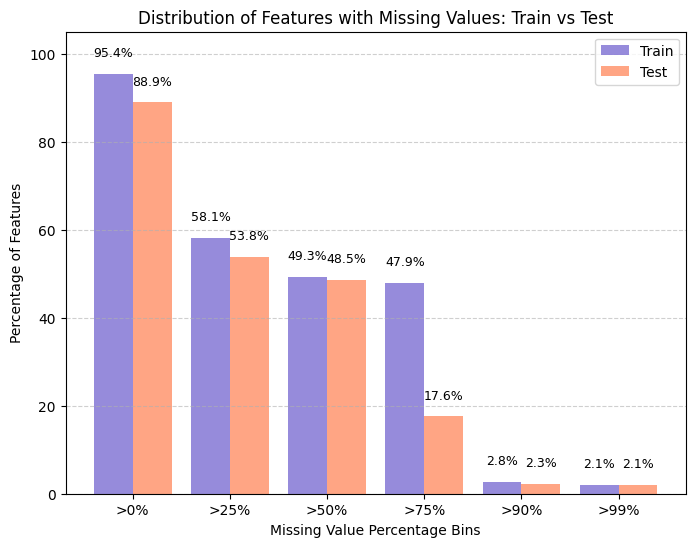

In [ ]:
plot_missing_values(train, test)

- Almost all features have missing values (>0%) in both datasets (Train: 95.4%, Test: 88.9%).

- A significant difference appears in the >75% missing range, where train (47.9%) has more missing features than test (17.6%).

- This indicates that missing values are widespread and may require imputation or feature removal.

In [ ]:
analyze_missing_values(train, top_n=20)  # Get top 20 columns with highest missing %

Name   dtypes  Missing(%)  Uniques
417  id_24   object   99.196159       12
418  id_25   object   99.130965      341
400  id_07  float32   99.127070       84
401  id_08  float32   99.127070       94
414  id_21  float32   99.126393      490
419  id_26   object   99.125715       95
420  id_27   object   99.124699        2
416  id_23   object   99.124699        3
415  id_22  float32   99.124699       25
14   dist2  float32   93.628374     1751
37      D7  float32   93.409930      597
411  id_18  float32   92.360721       18
43     D13  float32   89.509263      577
44     D14  float32   89.469469      802
42     D12  float32   89.041047      635
396  id_03  float32   88.768923       24
397  id_04  float32   88.768923       15
36      D6  float32   87.606767      829
426  id_33   object   87.589494      260
403  id_10  float32   87.312290       62

In [ ]:
analyze_missing_values(train, bottom_n=20)  # Get bottom 20 columns with lowest missing %

Name   dtypes  Missing(%)  Uniques
25              C9  float32         0.0      205
30             C14  float32         0.0     1108
29             C13  float32         0.0     1597
28             C12  float32         0.0     1199
27             C11  float32         0.0     1476
26             C10  float32         0.0     1231
2    TransactionDT    int32         0.0   573349
3   TransactionAmt  float32         0.0    20902
4        ProductCD   object         0.0        5
22              C6  float32         0.0     1328
5            card1   object         0.0    13553
24              C8  float32         0.0     1253
23              C7  float32         0.0     1103
21              C5  float32         0.0      319
20              C4  float32         0.0     1260
19              C3  float32         0.0       27
18              C2  float32         0.0     1216
17              C1  float32         0.0     1657
1          isFraud     int8         0.0        2
0    TransactionID    int32         0.0   590540

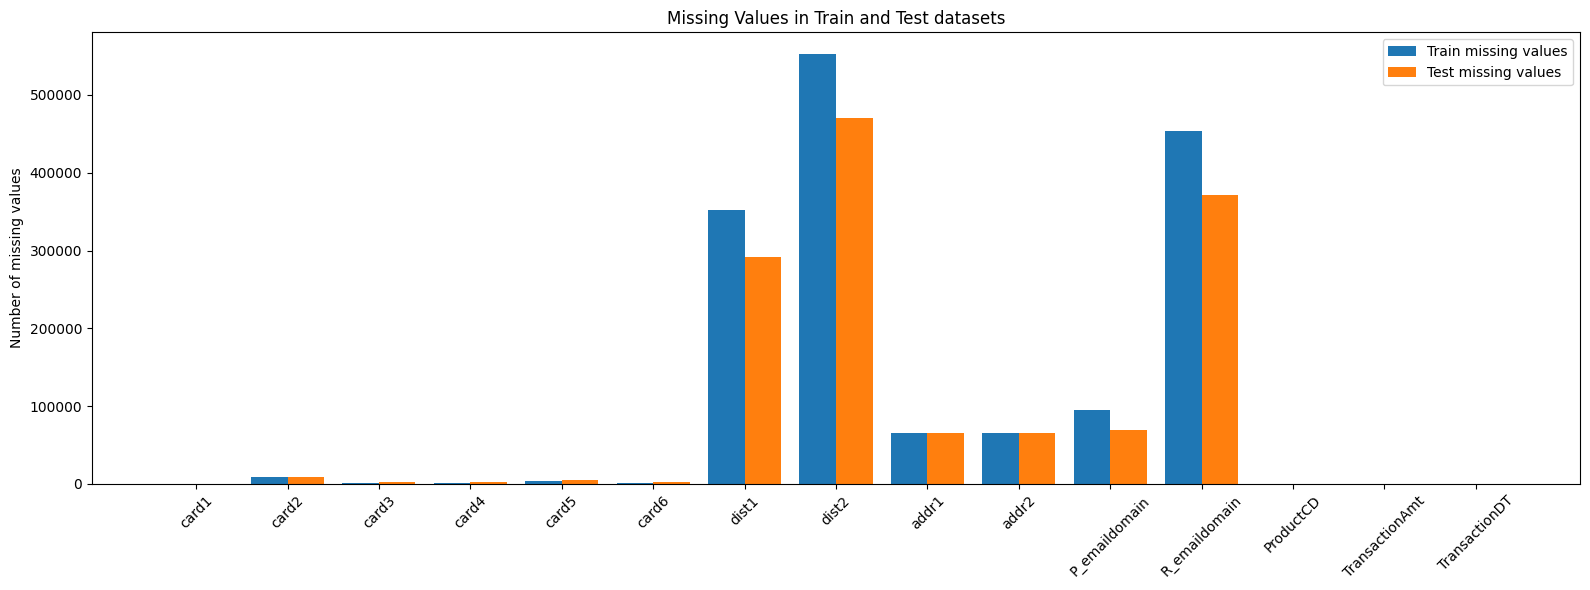

In [ ]:
columns_to_check = [
    'card1', 'card2', 'card3', 'card4', 'card5', 'card6',
    'dist1', 'dist2', 'addr1', 'addr2',
    'P_emaildomain', 'R_emaildomain', 'ProductCD',
    'TransactionAmt', 'TransactionDT'
]

plot_missing_specific_columns(train, test, columns_to_check)

Meaningful features such as cards features have almost no missing values. card1 which has the highest variance range is fully populated, P domain and addr1 have also high population

In [ ]:
analyze_missing_values(train, bottom_n=5, sort_by="uniques")  # Get bottom 5 columns with lowest unique values

Name   dtypes  Missing(%)  Uniques
55        V1  float32   47.293494        2
409    id_16   object   78.098012        2
161     V107  float32    0.053172        2
1    isFraud     int8    0.000000        2
119      V65  float32   13.055170        2

In [ ]:
analyze_missing_values(test, bottom_n=5, sort_by="uniques")  # Get bottom 5 columns with lowest unique values

Name   dtypes  Missing(%)  Uniques
408  id_16   object   64.507739        2
49      M5   object   52.432011        2
46      M2   object   29.911437        2
51      M7   object   39.797135        2
160   V107  float32    0.000000        1

We can see that V107 has only single value, we will drop it.

### Target Distribution

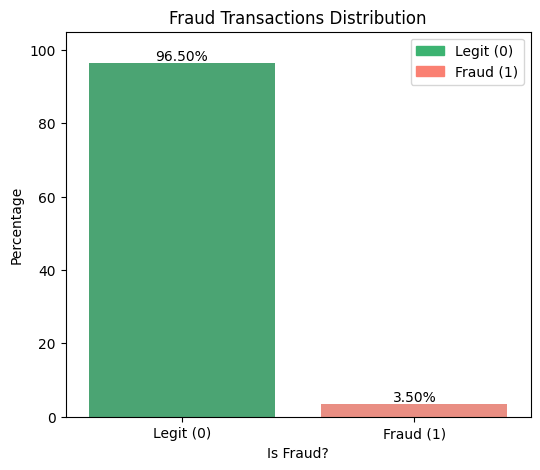

In [ ]:
plot_fraud_distribution(train)

The graph shows a highly imbalanced dataset where 96.5% of transactions are legitimate (Legit 0), while only 3.5% are fraudulent (Fraud 1), highlighting the challenge of detecting fraud in this dataset.

### TransactionDT

- **TransactionDT** first value is 86400, which corresponds to the number of seconds in a day (60 * 60 * 24 = 86400) so the unit is seconds. Using this, we know the data spans 6 months, as the maximum value is 15811131, which would correspond to day 182.

- **New time-based features** (hour, day, week, month) can help analyze patterns in fraudulent activity.  

- **Train and test datasets belong to different time periods**, making time-based splitting a logical approach.  

- **Fraudulent transactions are more frequent** between **7 AM - 10 AM**, peaking around these hours.  

- **Fraud rates are lowest** between **2 PM - 4 PM**, indicating potential time-based trends.  

- **Time-of-day can be categorized into different risk levels** based on fraud likelihood.  


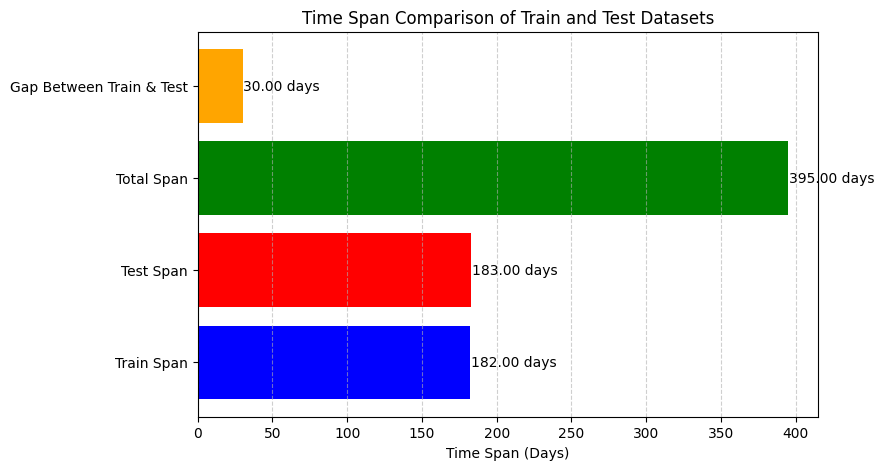

In [ ]:
plot_time_span(train, test)

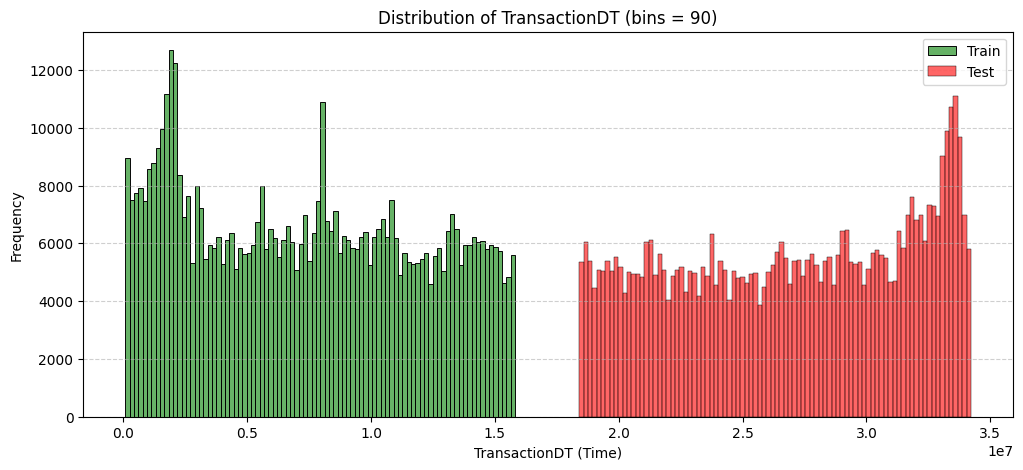

In [ ]:
plot_transaction_distribution(train, test, bins=90, train_color="green", test_color="red")

The TransactionDT distribution graph shows that the train and test datasets belong to different time periods.
Time-based splitting prevents the model from cheating by learning future information, ensuring it generalizes to real-world fraud detection. Additionally, transaction frequency appears to be higher in the first period of the train dataset and the last period of the test dataset compared to other periods.

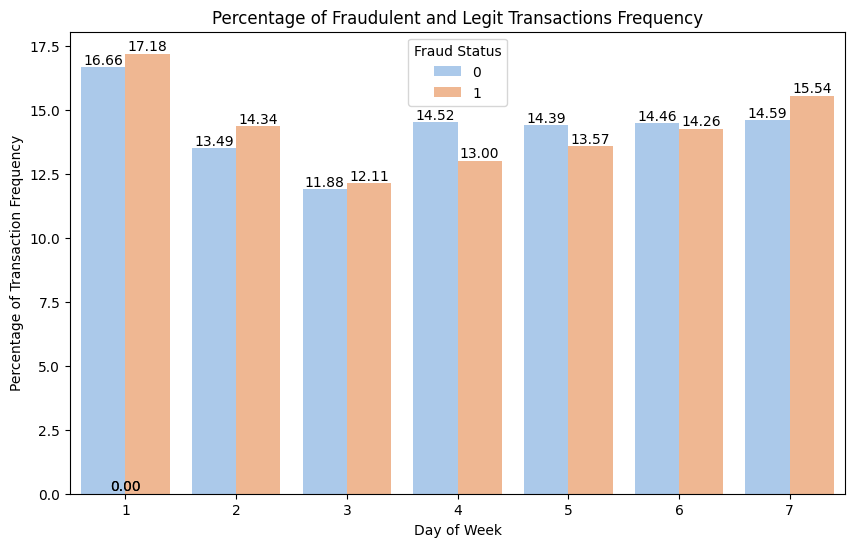

In [ ]:
train['day'] = ((train['TransactionDT']//(3600*24)-1)%7)+1
test['day'] = ((test['TransactionDT']//(3600*24)-1)%7)+1
plot_fraud_transaction_distribution(train)

Fraudulent transactions follow a similar pattern to legit ones across days.
Some minor differences, like on day 1, where fraud transactions are slightly higher.

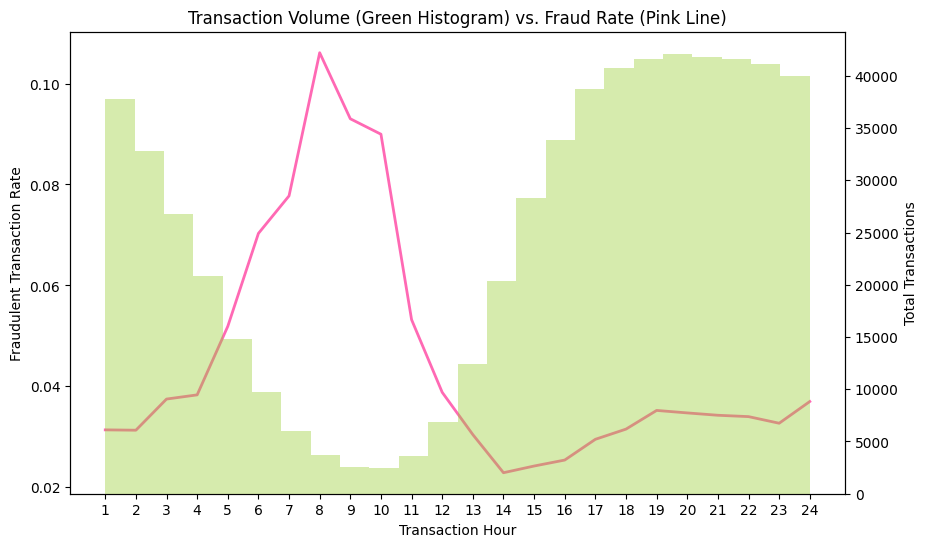

In [ ]:
train['hour'] = ((train['TransactionDT']//3600)%24)+1
test['hour'] = ((test['TransactionDT']//3600)%24)+1
plot_hourly_fraud_trend(train)

The graph illustrates the relationship between transaction volume (green histogram) and the fraud rate (pink line) across different hours of the day.

The highest fraud rate occurs between 7 AM and 10 AM, where fraudulent transactions reach over 10% of total transactions.

The lowest fraud rate is observed between 2 PM (14) and 4 PM (16), indicating a safer period for transactions.
General Trend (4 AM - 12 PM Higher Risk)

The fraud rate is significantly higher from 4 AM to 12 PM compared to the rest of the day.

While the total number of transactions is highest between 4 PM - 10 PM, fraud rates remain relatively low during these hours.

Feature Engineering: Create a new feature categorizing hours into risk levels (e.g., High-Risk, Medium-Risk, Low-Risk periods).

### TransactionAmt

In [ ]:
describeFraudLegit(train, test, 'TransactionAmt')

TransactionAmt         Train Train_Fraud   Train_Legit        Test
0           count      590540.0     20663.0      569877.0    506691.0
1            mean    135.027161  149.244781    134.511658  134.725571
2             std    239.162689  232.210709     239.39801  245.790817
3             min         0.251       0.292         0.251       0.018
4             25%     43.320999   35.043999     43.970001        40.0
5             50%     68.769001        75.0          68.5   67.949997
6             75%         125.0       161.0         120.0       125.0
7             max  31937.390625      5191.0  31937.390625     10270.0
8          unique         20902        2515         20560       14119
9             NaN             0           0             0           0
10      NaN_share           0.0         0.0           0.0         0.0

The maximum value in the training set is significantly higher than in the test set (30K vs. 10K), which suggests a possible outlier. Let's examine whether the training set contains any outliers.

In [ ]:
train[train.TransactionAmt>10000]

TransactionID  isFraud  TransactionDT  TransactionAmt ProductCD  \
274336        3261336        0        6652360    31937.390625         W   
274339        3261339        0        6652391    31937.390625         W   

        card1  card2  card3       card4  card5   card6  addr1  addr2  dist1  \
274336  16075  514.0  150.0  mastercard  102.0  credit  205.0   87.0   27.0   
274339  16075  514.0  150.0  mastercard  102.0  credit  205.0   87.0   27.0   

        dist2 P_emaildomain R_emaildomain   C1   C2   C3   C4   C5   C6   C7  \
274336    NaN     yahoo.com           NaN  1.0  2.0  0.0  0.0  1.0  1.0  0.0   
274339    NaN     yahoo.com           NaN  1.0  2.0  0.0  0.0  1.0  1.0  0.0   

         C8   C9  C10  C11  C12  C13  C14   D1  D2   D3   D4   D5  D6  D7  D8  \
274336  0.0  1.0  0.0  1.0  0.0  0.0  0.0  0.0 NaN  0.0  0.0  0.0 NaN NaN NaN   
274339  0.0  1.0  0.0  1.0  0.0  0.0  0.0  0.0 NaN  0.0  0.0  0.0 NaN NaN NaN   

        D9  D10  D11  D12  D13  D14  D15 M1 M2 M3   M4  ... V332 V333 V334  \
274336 NaN  0.0  0.0  NaN  NaN  NaN  0.0  T  T  T  NaN  ...  NaN  NaN  NaN   
274339 NaN  0.0  0.0  NaN  NaN  NaN  0.0  T  T  T  NaN  ...  NaN  NaN  NaN   

       V335 V336  V337  V338  V339  id_01  id_02  id_03  id_04  id_05  id_06  \
274336  NaN  NaN   NaN   NaN   NaN    NaN    NaN    NaN    NaN    NaN    NaN   
274339  NaN  NaN   NaN   NaN   NaN    NaN    NaN    NaN    NaN    NaN    NaN   

        id_07  id_08  id_09  id_10  id_11  id_12  id_13  id_14  id_15  id_16  \
274336    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
274339    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   

        id_17  id_18  id_19  id_20  id_21  id_22  id_23  id_24  id_25  id_26  \
274336    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
274339    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   

        id_27  id_28  id_29  id_30  id_31  id_32  id_33  id_34  id_35  id_36  \
274336    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
274339    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   

        id_37  id_38  DeviceType  DeviceInfo  day  hour  
274336    NaN    NaN         NaN         NaN    6    24  
274339    NaN    NaN         NaN         NaN    6    24  

[2 rows x 436 columns]

There are only two transactions exceeding $10,000, and they appear to be duplicates. To prevent overfitting, we can remove them. For example, in tree-based models, these transactions could influence leaf nodes in a way that does not generalize well to new data. However, we should not remove these rows from the test dataset, as it is used for making predictions and submitting results to Kaggle.

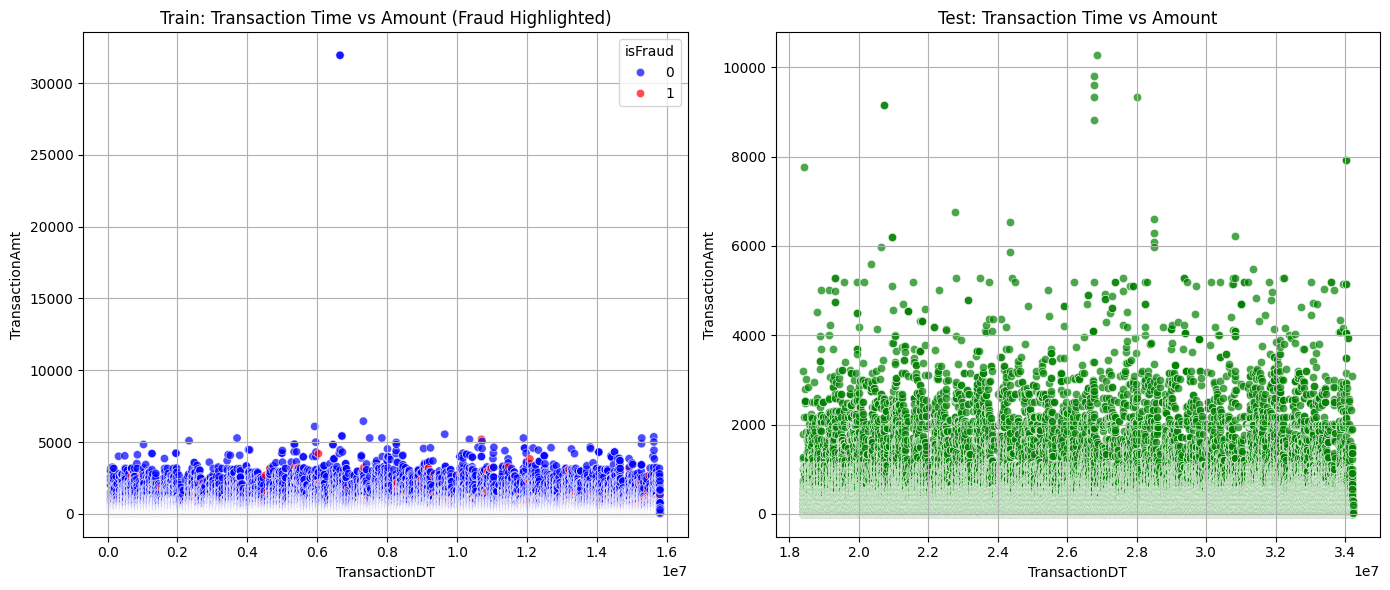

In [ ]:
plot_transaction_scatter(train, test)

In [ ]:
lower_outliers, upper_outliers = detect_outliers_iqr(train, 'TransactionAmt')

Number of lower outliers (< Q1 - 3*IQR): 0
Number of upper outliers (> Q3 + 3*IQR): 36422


No outliers below Q1 - 3*IQR:
There are 0 observations below the lower bound, meaning there aren’t any extremely low transaction amounts that are considered outliers.

Many high-value outliers above Q3 + 3*IQR:
A total of 36,420 transactions exceed the upper bound, meaning these transactions are significantly higher than the typical range of transaction amounts. These extreme values might distort our model’s understanding of normal transactions, on the other hand high transaction amount may be corralted with fraud.

Why remove transactions above 10,000?
Since we see that many transactions are classified as extreme outliers, we take a practical decision to remove transactions above 10,000. This threshold helps reduce the influence of very large values that could skew the analysis or model training.

Since TransactionAmt contains extremely high values, applying a log transformation will help in improving visualization and making the distribution more interpretable.

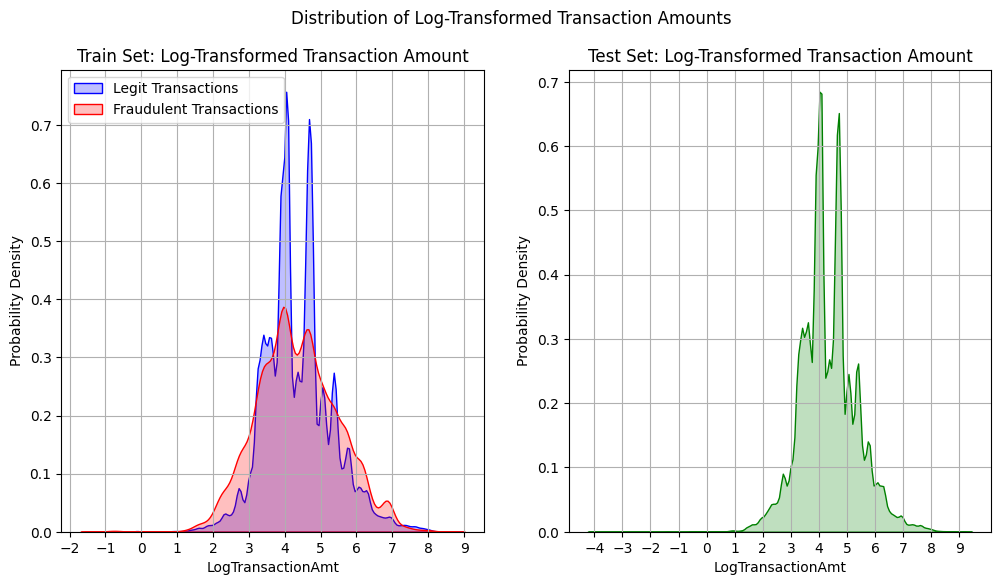

In [ ]:
train['LogTransactionAmt'] = np.log(train['TransactionAmt'])
test['LogTransactionAmt'] = np.log(test['TransactionAmt'])
log_std = train.LogTransactionAmt.std()
log_mean = train.LogTransactionAmt.mean()
log_mean - 1*log_std

plot_log_transaction_distribution(train, test)

Transactions with a LogTransactionAmt above 5.5 (244USD) or below 3.3 (27USD) are more often fraudulent. Meanwhile, transactions between 3.3 and 5.5 are mostly legit.

### ProductCD

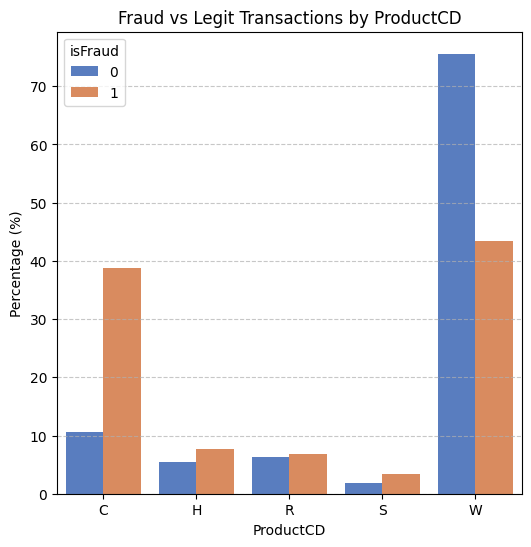

In [ ]:
plot_productcd_distribution(train)

The graph shows that 40% of fraudulent transactions are linked to Product C, while only 10% of legit transactions fall into this category. This suggests that if a transaction is from Product C, it has a higher chance of being fraudulent, though it doesn’t mean all Product C transactions are fraud.

To capture this pattern, we will add a feature indicating that Product C is high risk for fraud. This will help the model better differentiate between fraud and legit transactions.









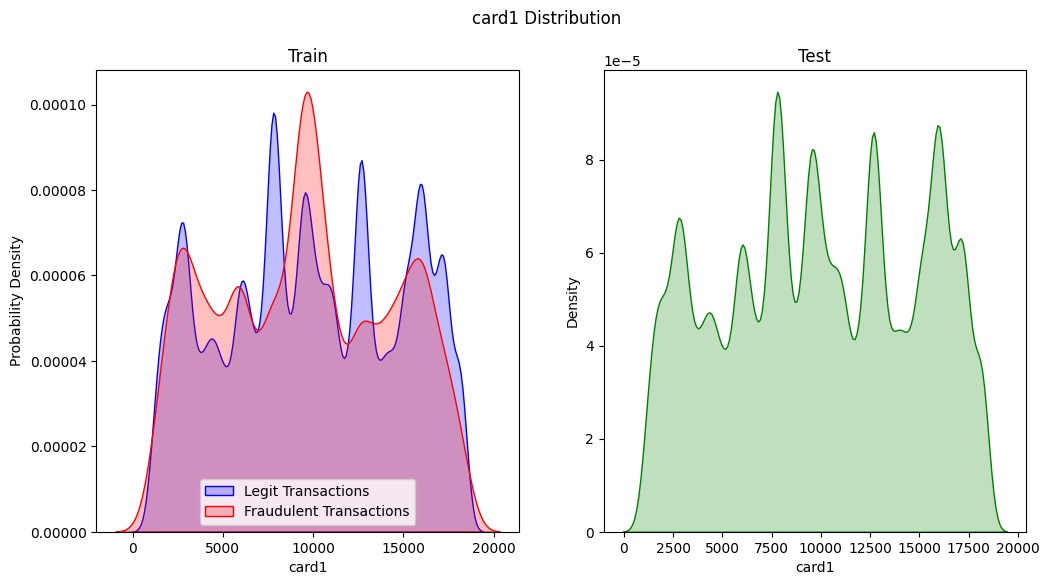

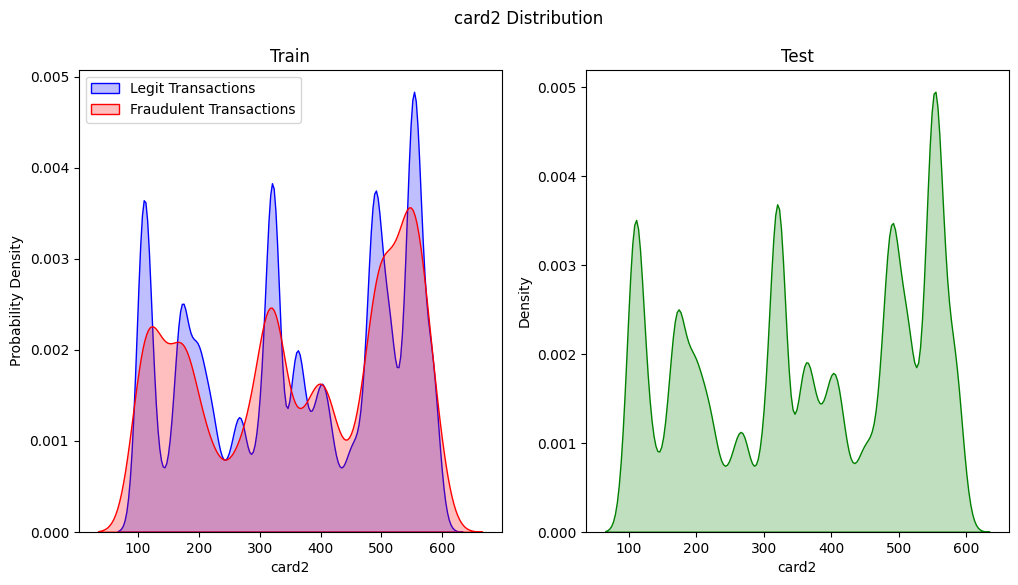

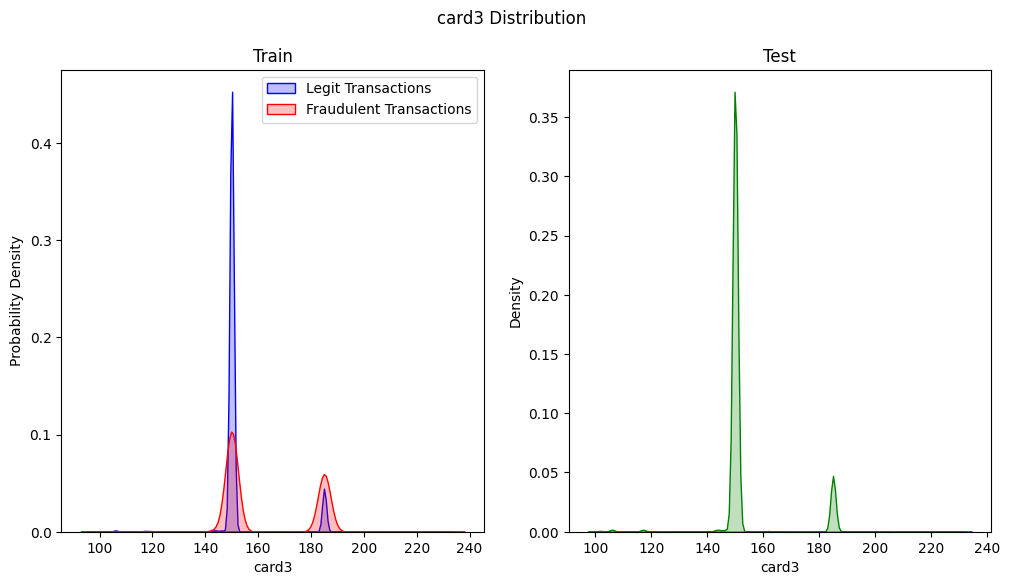

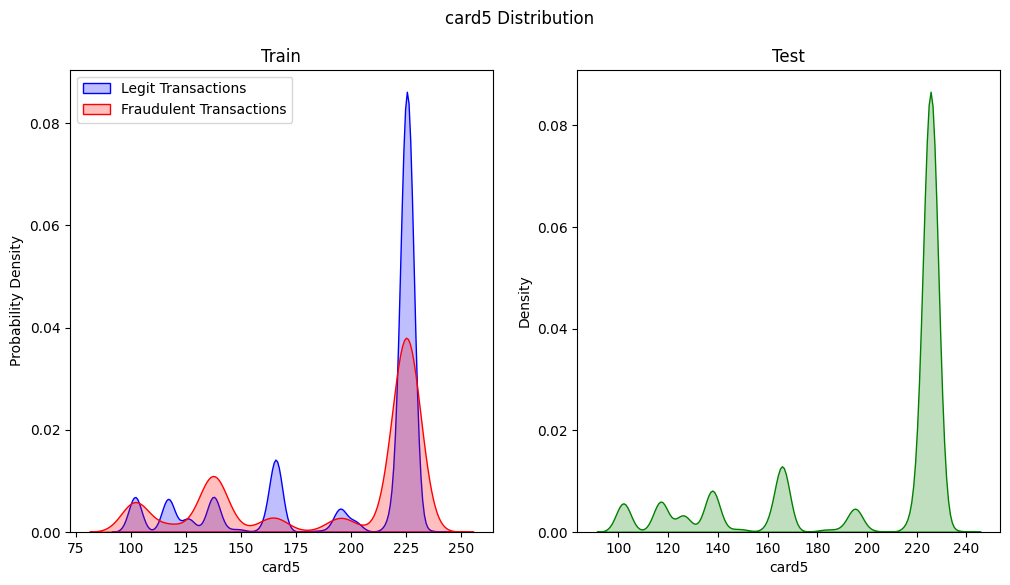

In [ ]:
plot_card_distribution(train, test, 'card1')
plot_card_distribution(train, test, 'card2')
plot_card_distribution(train, test, 'card3')
plot_card_distribution(train, test, 'card5')

Since card3 is a categorical variable, we notice that values around 150 are more commonly linked to legit transactions. Based on this pattern, we can create a new feature to categorize card3 into meaningful groups.

This Feature we will create in the feature engineering using


train, test = create_card_features(train, test)


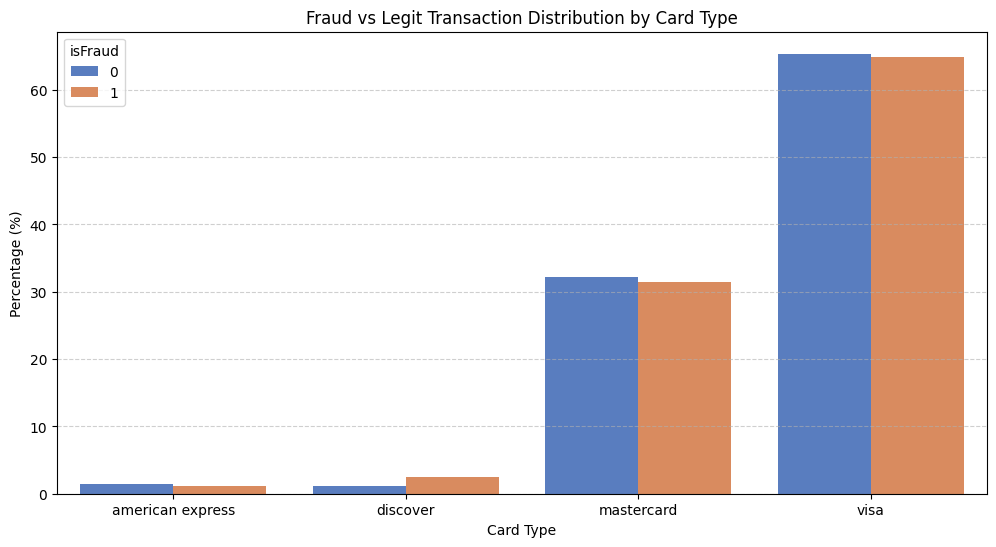

In [ ]:
plot_card4_distribution(train)


We can see that most of the transactions completed by visa and mastercard card types.

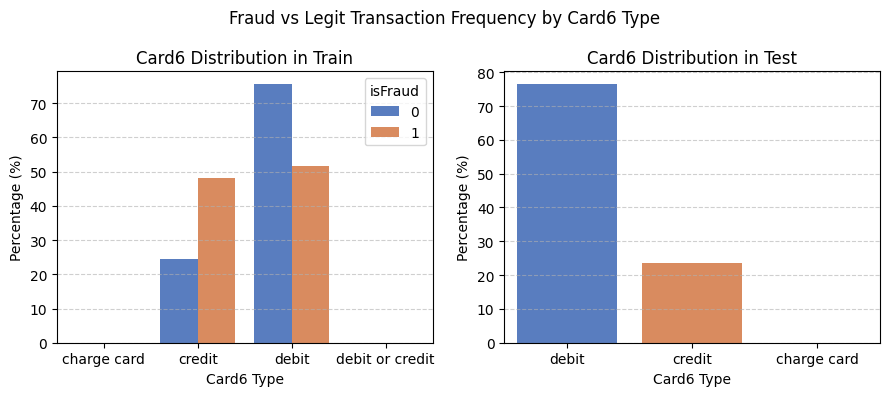

In [ ]:
plot_card6_distribution(train, test)

There are very few transactions for 'charge card' and 'debit or credit', and 'debit or credit' is not in the test data at all. Since there are not enough examples to see a clear pattern, and most transactions are 'debit', we can change these rare types to 'debit' to make the data more stable. - We will check it in the feature engineer

### Addr2 & Addr2

The addr1 field represents the Purchaser's Region, while addr2 indicates the Purchaser's Billing Country according to the Hoster data.



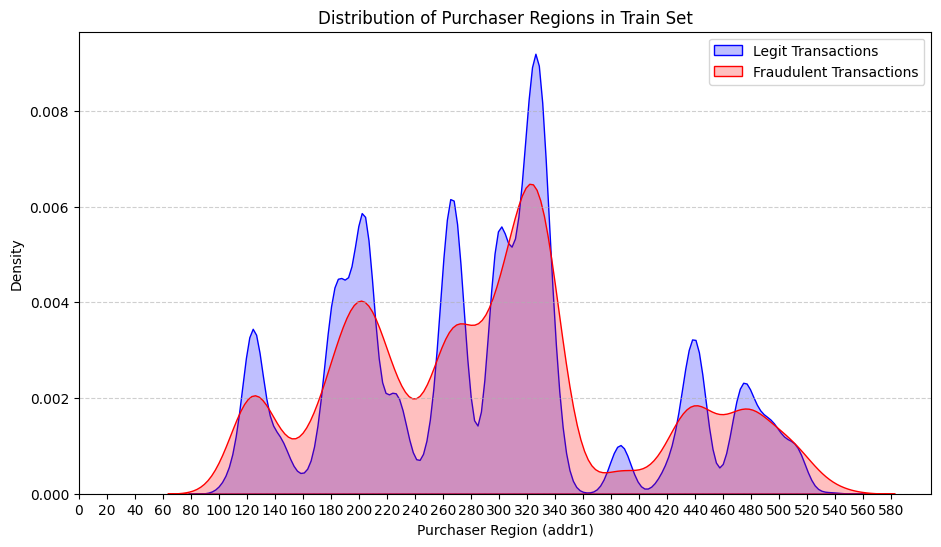

In [ ]:
plot_purchaser_region_distribution(train)

330-340 seems have higher frequency of fraud

In [ ]:
train_regions = train['addr1'].nunique()
test_regions = test['addr1'].nunique()

print(f'The Train dataset contains {train_regions} unique purchaser regions (addr1).')
print('Top 5 most common regions in Train:')
print(train['addr1'].value_counts().head(5))

print(f'\nThe Test dataset contains {test_regions} unique purchaser regions (addr1).')
print('Top 5 most common regions in Test:')
print(test['addr1'].value_counts().head(5))


The Train dataset contains 332 unique purchaser regions (addr1).
Top 5 most common regions in Train:
addr1
299.0    46335
325.0    42751
204.0    42020
264.0    39870
330.0    26287
Name: count, dtype: int64

The Test dataset contains 292 unique purchaser regions (addr1).
Top 5 most common regions in Test:
addr1
299.0    38710
204.0    35049
325.0    34151
264.0    32710
330.0    22100
Name: count, dtype: int64


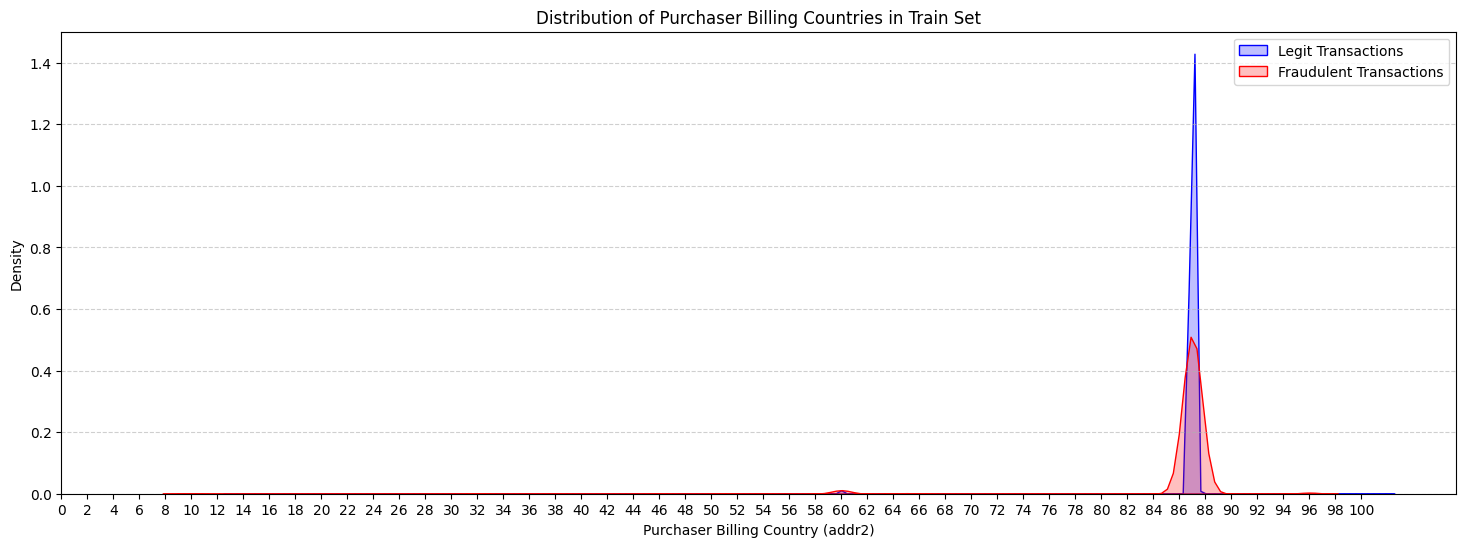

In [ ]:
plot_purchaser_billing_country_distribution(train)


Except for addresses 87, 60, and 96, there are too few samples for other addresses to find clear patterns. The graph shows that most transactions happen at address 87, with both legit (blue) and fraud (red) transactions. This means address 87 is the main location in the data, while other addresses don’t have enough data to learn useful fraud patterns.

In [ ]:
train_countries = train['addr2'].nunique()
test_countries = test['addr2'].nunique()

train_top_percentage = (train['addr2'].value_counts().values[0] / len(train['addr2'])) * 100
test_top_percentage = (test['addr2'].value_counts().values[0] / len(test['addr2'])) * 100

print(f'The Train dataset contains {train_countries} unique billing countries in addr2.')
print(f'The most common country (87) accounts for {train_top_percentage:.2f}% of the transactions.')
print('Top 5 most frequent billing countries in Train:')
print(train['addr2'].value_counts().head(5))

print(f'\nThe Test dataset contains {test_countries} unique billing countries in addr2.')
print(f'The most common country (87) accounts for {test_top_percentage:.2f}% of the transactions.')
print('Top 5 most frequent billing countries in Test:')
print(test['addr2'].value_counts().head(5))


The Train dataset contains 74 unique billing countries in addr2.
The most common country (87) accounts for 88.14% of the transactions.
Top 5 most frequent billing countries in Train:
addr2
87.0    520481
60.0      3084
96.0       638
32.0        91
65.0        82
Name: count, dtype: int64

The Test dataset contains 72 unique billing countries in addr2.
The most common country (87) accounts for 86.04% of the transactions.
Top 5 most frequent billing countries in Test:
addr2
87.0    435934
60.0      4041
96.0       608
32.0        61
65.0        49
Name: count, dtype: int64


### Dist1 & Dist2

In [ ]:
describeFraudLegit(train,test,'dist1')

dist1       Train Train_Fraud Train_Legit        Test
0       count    238269.0      4755.0    233514.0    215474.0
1        mean  118.502197  174.588852  117.360138   87.065269
2         std  371.947388  424.230988  370.618774  314.128754
3         min         0.0         0.0         0.0         0.0
4         25%         3.0         3.0         3.0         3.0
5         50%         8.0        10.0         8.0         8.0
6         75%        24.0        85.5        24.0        20.0
7         max     10286.0      4942.0     10286.0      8081.0
8      unique        2651         470        2635        1988
9         NaN      352271       15908      336363      291217
10  NaN_share    0.596524    0.769879    0.590238    0.574743

The average dist1 in fraudulent transactions is higher compared to legit transactions in the training data. This suggests that scammers tend to conduct fraudulent transactions from locations farther away from the cardholder’s registered address.

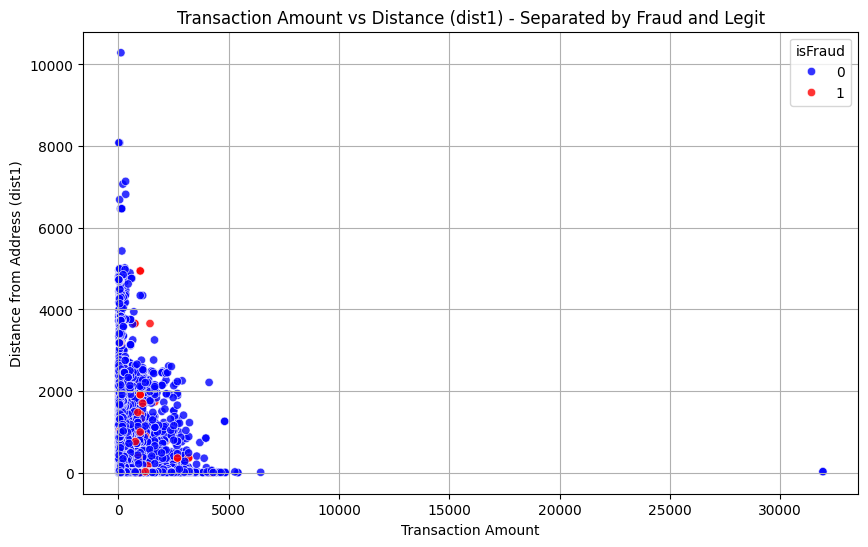

In [ ]:

plot_transactionamt_vs_distance(train)

Transactions with dist1 greater than 6000 in the training data are clear outliers, so it's best to remove them to ensure a cleaner dataset.

We will remove it in the feature engineer with
train.drop(train[train.dist1>6000].index, axis=0, inplace=True)


In [ ]:
describeFraudLegit(train,test,'dist2')

dist2       Train Train_Fraud Train_Legit        Test
0       count     37627.0      3731.0     33896.0     36436.0
1        mean  231.855423   201.47226  235.199753  237.175049
2         std  529.039307  451.588928  536.805786  556.451721
3         min         0.0         0.0         0.0         0.0
4         25%         7.0         7.0         7.0         7.0
5         50%        37.0        49.0        36.0        44.0
6         75%       206.0       233.0       206.0       196.0
7         max     11623.0      9337.0     11623.0      9213.0
8      unique        1751         344        1723        1814
9         NaN      552913       16932      535981      470255
10  NaN_share    0.936284    0.819436     0.94052     0.92809

large percentages of missing values (93%) ...



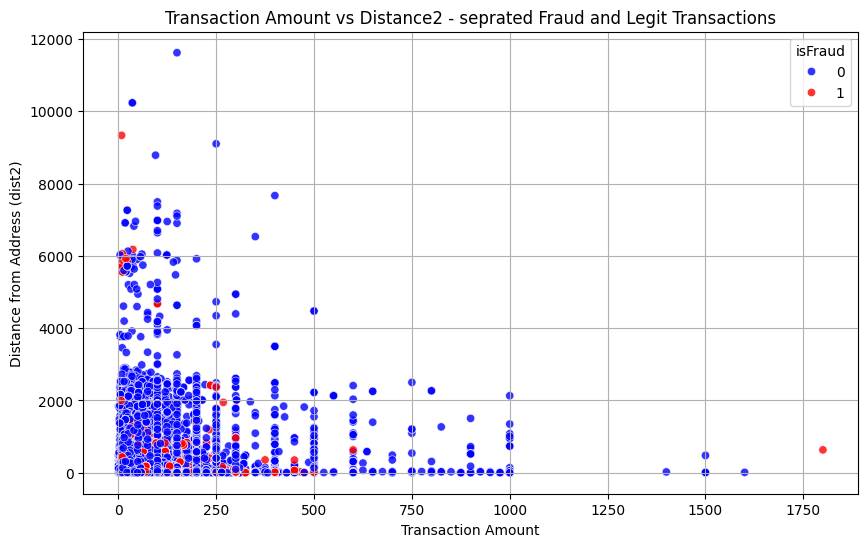

In [ ]:
plot_transactionamt_vs_distance2(train)

Its clearly for us that observations that dist2> 8000 are outliers in train so we will remove them in the feature engineer using:

train.drop(train[train.dist2>8000].index, axis=0, inplace=True)



### Email Domain

Now we will move forward for the email domains, purcaser as P and recipient as R

In [ ]:
train['R_emaildomain'].value_counts().head(10)

R_emaildomain
gmail.com        57147
hotmail.com      27509
anonymous.com    20529
yahoo.com        11842
aol.com           3701
outlook.com       2507
comcast.net       1812
yahoo.com.mx      1508
icloud.com        1398
msn.com            852
Name: count, dtype: int64

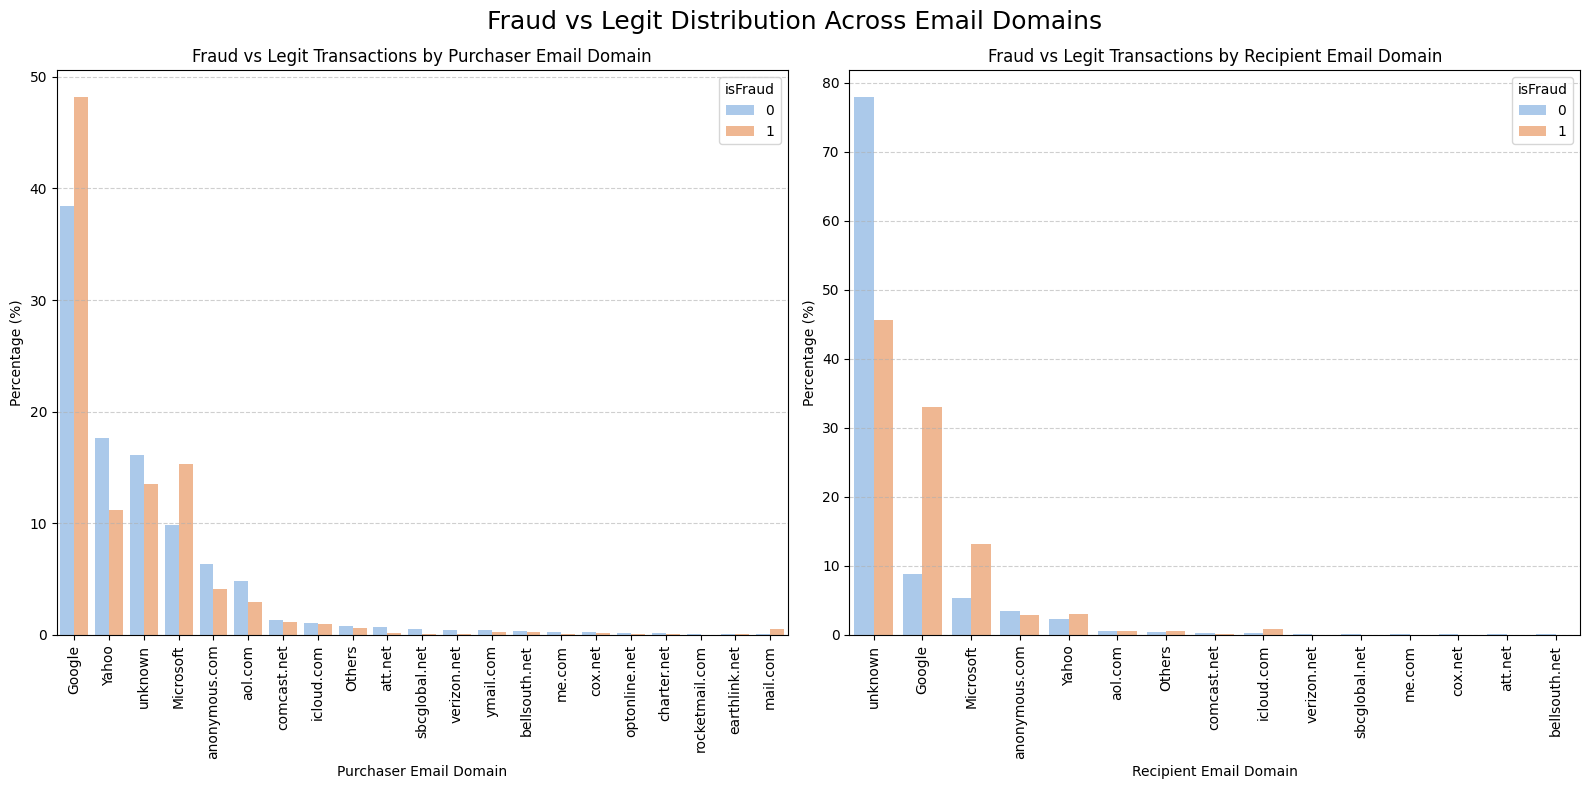

In [ ]:
process_email_domains(train,test)
plot_email_domain_distribution(train)

**Purchaser Email Domains** (Left Graph):

Most transactions come from Google, Yahoo, and Microsoft email domains.
Fraudulent transactions (orange) are more frequent on Google and Microsoft domains compared to other domains.
"Nonf" and anonymous.com emails also show a significant fraud presence, suggesting they might be riskier.


**Recipient Email Domains** (Right Graph):

"Nonf" (unknown) email domain is the most common for both legit and fraudulent transactions.
Fraudulent transactions are notably high for Google and Microsoft domains.
Some lesser-known domains have small transaction volumes, making them less informative.


### C Variables ###
The variables C1 to C14 are continuous features, representing counts such as the number of addresses linked to a payment card. However, their exact meanings are masked.

To better understand these features, we can analyze their distribution, summary statistics, and scatterplots to identify potential outliers.

Fortunately, there are no missing values in Train, and only three missing values in Test, making the data relatively complete.

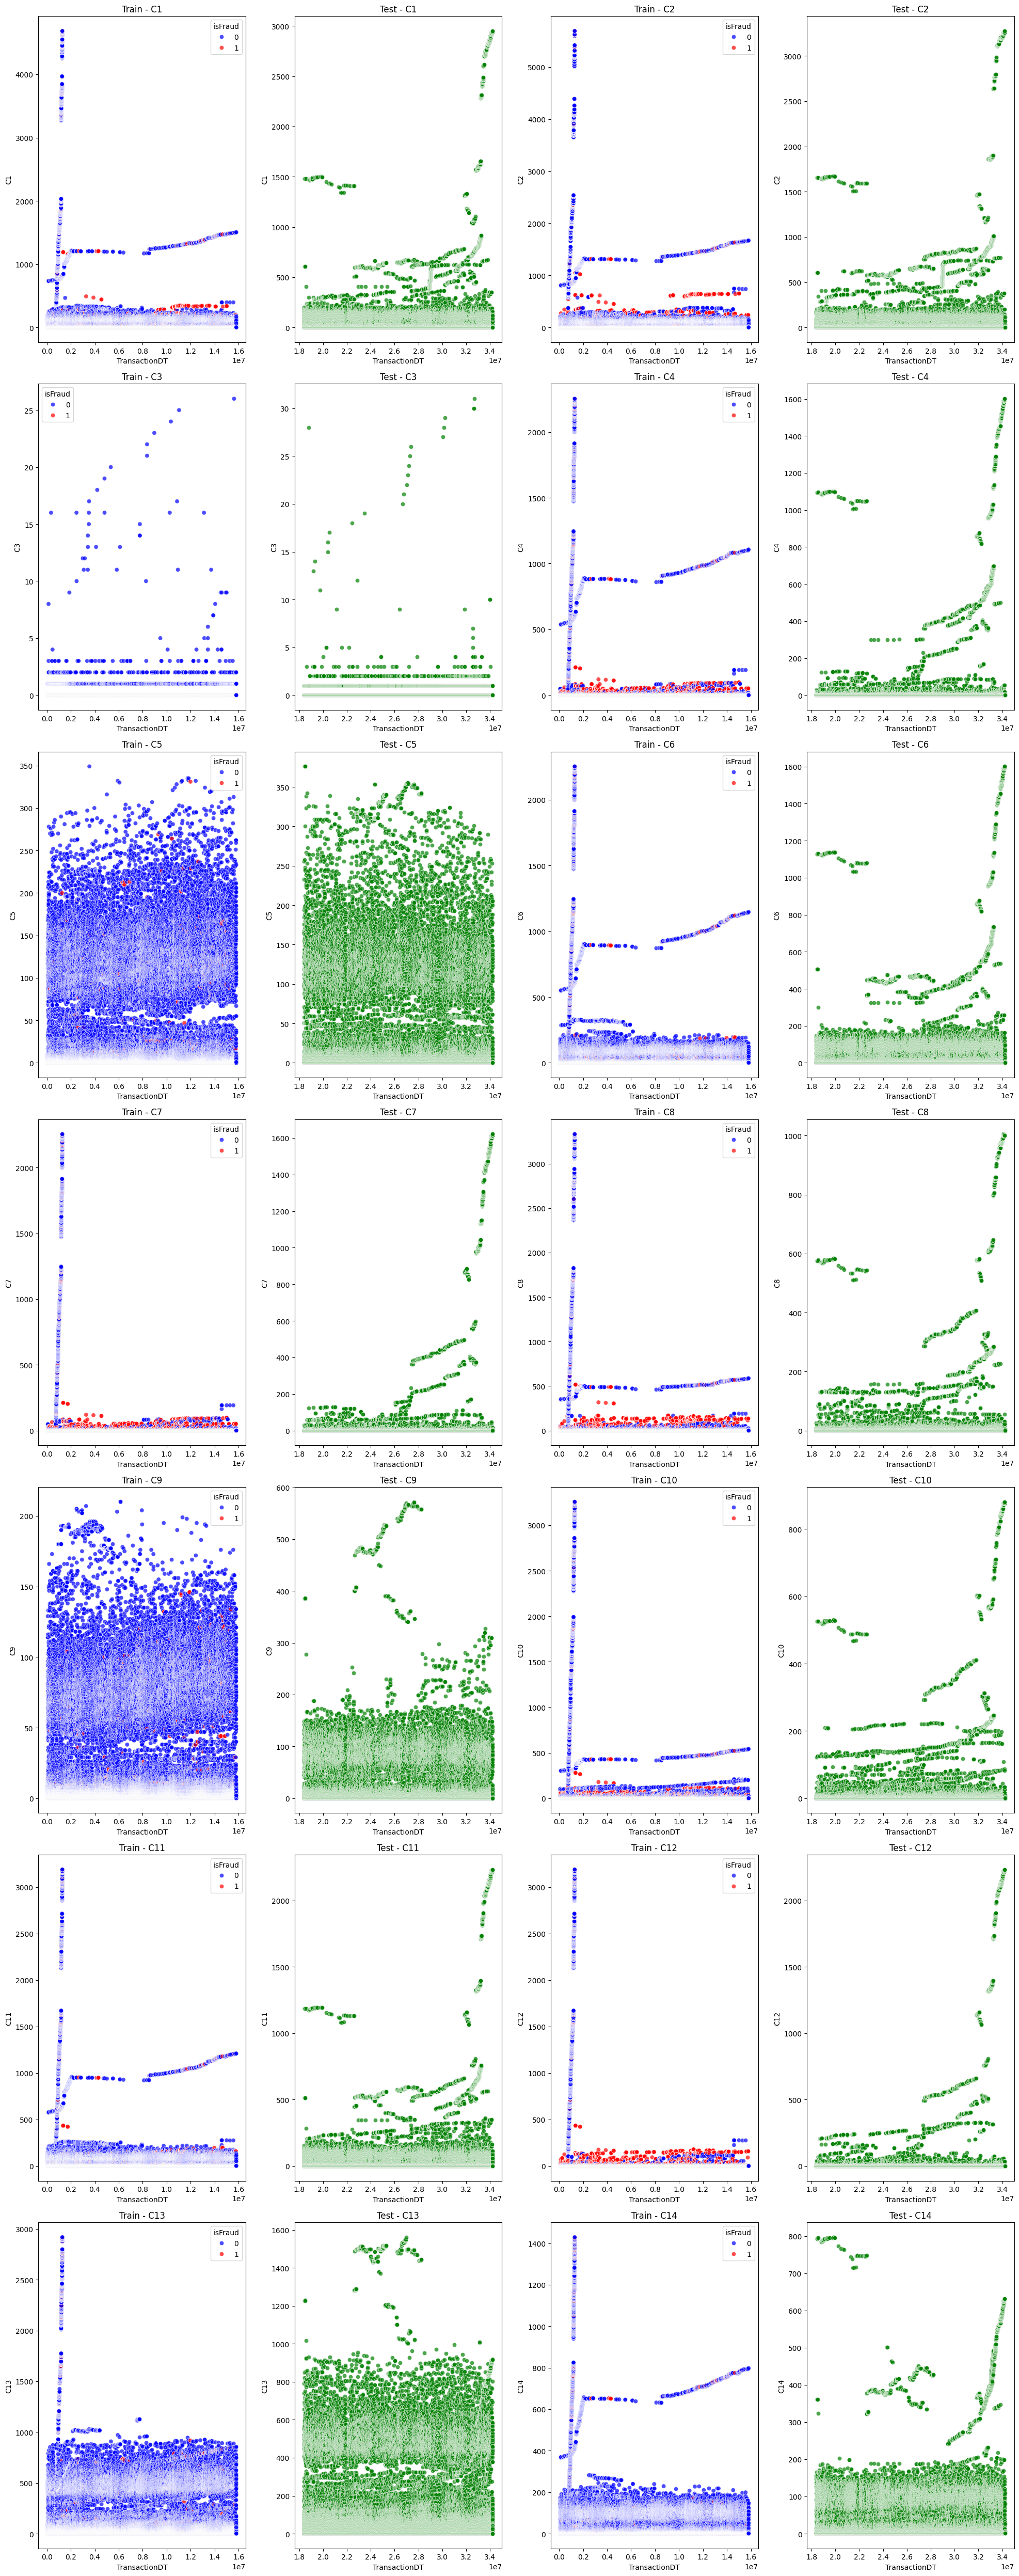

In [ ]:
plot_continuous_features_over_time(train, test)

The features C5 and C9 show no significant outliers.

However, other C variables contain extreme outliers, particularly within the TransactionDT range of 1,028,000 to 1,199,904 (Days 4-6). During this period, there was a notable increase in the number of addresses linked to a single payment card.

So we will remove some outliers of the features in the feature engineer using our function -> remove_outliers(train)





In [ ]:
c_features_description = describe_continuous_features(train, test)
c_features_description

C1_desc                                                 C2_desc  \
           C1     Train Train_Fraud Train_Legit       Test         C2   
0       count  589527.0     20548.0    568979.0   506688.0      count   
1        mean  9.476123   20.071199    9.093493  10.093211       mean   
2         std   52.9412    89.35096   51.144653  79.332352        std   
3         min       0.0         0.0         0.0        0.0        min   
4         25%       1.0         1.0         1.0        1.0        25%   
5         50%       1.0         2.0         1.0        1.0        50%   
6         75%       3.0         6.0         3.0        3.0        75%   
7         max    1505.0      1494.0      1505.0     2950.0        max   
8      unique       988         395         918       1174     unique   
9         NaN         0           0           0          3        NaN   
10  NaN_share       0.0         0.0         0.0   0.000006  NaN_share   

                                                    C3_desc            \
        Train Train_Fraud Train_Legit       Test         C3     Train   
0    589527.0     20548.0    568979.0   506688.0      count  589527.0   
1    9.811741   27.187756    9.184226  10.714635       mean  0.005654   
2   60.140327  116.025467   57.061378  88.846107        std  0.150568   
3         0.0         0.0         0.0        0.0        min       0.0   
4         1.0         1.0         1.0        1.0        25%       0.0   
5         1.0         2.0         1.0        1.0        50%       0.0   
6         3.0         7.0         3.0        3.0        75%       0.0   
7      1670.0      1657.0      1670.0     3275.0        max      26.0   
8         958         474         824       1123     unique        27   
9           0           0           0          3        NaN         0   
10        0.0         0.0         0.0   0.000006  NaN_share       0.0   

                                        C4_desc                         \
   Train_Fraud Train_Legit      Test         C4      Train Train_Fraud   
0      20548.0    568979.0  506688.0      count   589527.0     20548.0   
1     0.000243    0.005849  0.027403       mean   1.736709    7.096506   
2     0.015596    0.153228  0.227593        std  32.232384   54.853027   
3          0.0         0.0       0.0        min        0.0         0.0   
4          0.0         0.0       0.0        25%        0.0         0.0   
5          0.0         0.0       0.0        50%        0.0         1.0   
6          0.0         0.0       0.0        75%        0.0         2.0   
7          1.0        26.0      31.0        max     1107.0      1098.0   
8            2          27        31     unique        699         137   
9            0           0         3        NaN          0           0   
10         0.0         0.0  0.000006  NaN_share        0.0         0.0   

                            C5_desc                                     \
   Train_Legit      Test         C5      Train Train_Fraud Train_Legit   
0     568979.0  506688.0      count   589527.0     20548.0    568979.0   
1     1.543147  2.385875       mean   5.581091     1.41459    5.731559   
2    31.101234  41.93726        std  25.820707   12.981809    26.12956   
3          0.0       0.0        min        0.0         0.0         0.0   
4          0.0       0.0        25%        0.0         0.0         0.0   
5          0.0       0.0        50%        0.0         0.0         0.0   
6          0.0       1.0        75%        1.0         0.0         1.0   
7       1107.0    1601.0        max      349.0       331.0       349.0   
8          659       728     unique        319         124         319   
9            0         3        NaN          0           0           0   
10         0.0  0.000006  NaN_share        0.0         0.0         0.0   

                 C6_desc                                                \
         Test         C6      Train Train_Fraud Train_Legit       Test   
0    506688.0      count   58952

D1-D15 represent timedelta features, such as the time difference (in days) between a transaction and a previous event.


In [ ]:
d_features_description = describe_timedelta_features(train, test)
d_features_description

D1_desc                                                    D2_desc  \
           D1       Train Train_Fraud Train_Legit        Test         D2   
0       count    588258.0     20502.0    567756.0    500660.0      count   
1        mean   94.445816   38.720222   96.458145  108.207489       mean   
2         std  157.778671  100.840897  158.946457  176.680496        std   
3         min         0.0         0.0         0.0         0.0        min   
4         25%         0.0         0.0         0.0         0.0        25%   
5         50%         3.0         0.0         4.0         5.0        50%   
6         75%       122.0        14.0       127.0       148.0        75%   
7         max       640.0       637.0       640.0       641.0        max   
8      unique         641         577         641         642     unique   
9         NaN        1269          46        1223        6031        NaN   
10  NaN_share    0.002153    0.002239    0.002149    0.011903  NaN_share   

                                                      D3_desc             \
         Train Train_Fraud Train_Legit        Test         D3      Train   
0     309448.0      7854.0    301594.0    271922.0      count   327259.0   
1   169.639282   77.887192  172.028671  188.666595       mean  28.336662   
2   177.327423  128.797089  177.814346  197.109451        std  62.365009   
3          0.0         0.0         0.0         0.0        min        0.0   
4         26.0         2.0        27.0        26.0        25%        1.0   
5         97.0        16.0       100.0       112.0        50%        8.0   
6        276.0        95.0       281.0       305.0        75%       27.0   
7        640.0       637.0       640.0       641.0        max      819.0   
8          641         541         641         642     unique        649   
9       280079       12694      267385      234769        NaN     262268   
10    0.475091    0.617773    0.469938    0.463338  NaN_share   0.444879   

                                         D4_desc                          \
   Train_Fraud Train_Legit       Test         D4       Train Train_Fraud   
0       9570.0    317689.0   303549.0      count    420618.0     14456.0   
1    11.732183   28.836853  33.394726       mean  140.199875   72.040886   
2    42.005215   62.766914  82.558319        std   191.07872  140.737823   
3          0.0         0.0        0.0        min      -122.0         0.0   
4          0.0         1.0        1.0        25%         0.0         0.0   
5          1.0         8.0        7.0        50%        26.0         1.0   
6          5.0        28.0       28.0        75%       254.0        60.0   
7        582.0       819.0     1076.0        max       869.0       667.0   
8          260         649        887     unique         808         605   
9        10978      251290     203142        NaN      168909        6092   
10    0.534261    0.441651   0.400919  NaN_share    0.286516    0.296477   

                              D5_desc                                     \
   Train_Legit        Test         D5      Train Train_Fraud Train_Legit   
0     406162.0    429840.0      count   280198.0     10797.0    269401.0   
1   142.625763  175.060791       mean   42.34549    13.68695   43.494064   
2   192.365936  250.476456        std  88.993126   51.930687   89.990295   
3       -122.0         0.0        min        0.0         0.0         0.0   
4          0.0         0.0        25%        1.0         0.0         1.0   
5         28.0        21.0        50%       10.0         0.0        10.0   
6        261.0       290.0        75%       32.0         3.0        34.0   
7        869.0      1091.0        max      819.0       625.0       819.0   
8          808        1056     unique        688         339         688   
9       162817       76851        NaN     309329        9751      299578   
10    0.286156    0.151672  NaN_share   0.524707    0.474547    0.526519   

                  D6_desc                         

D2,D3,D5,D6,D7,D8,D9,D11,D12,D13,D14 have higher than 40% NaNshare

D6-D9, D12-D13 have  ~ 90% of missing value

In [ ]:
#plot_timedelta_features_over_time(train, test)

def normalize_d_features(train: pd.DataFrame, test: pd.DataFrame) -> Tuple[pd.DataFrame, ...]:
    train['D1n'] = np.floor(train.TransactionDT / (24*60*60)) - train.D1
    test['D1n'] = np.floor(test.TransactionDT / (24*60*60)) - test.D1
    return train, test

train,_ = normalize_d_features(train,test);

train[['TransactionDT','D1','D1n']].tail(2)

# 15811088 / 86400 = 182

TransactionDT    D1    D1n
590538       15811088  22.0  160.0
590539       15811131   0.0  182.0

Most D features show a monotonic increase with TransactionDT, which is expected since they are described by Vesta as timedelta features—likely representing the time difference (e.g., days) between transactions. This pattern aligns with their intended purpose.

We think that D1 tells us how many days have passed since the credit card was first used. If we subtract this from the transaction day, we get a value that shows how long the card has been active before that transaction. This helps us understand the card's history for each customer.



If we assume D1 represents the first day the credit card was used, then:

D1 should always be less than or equal to the transaction day because
transactions cannot happen before the credit card exists.
If, after the transformation, D1n becomes negative, it means the transaction is supposedly happening before the card was even first used—which is logically impossible.
This strongly suggests a fraudulent transaction because it indicates manipulated timestamps or synthetic data.

### M1 - M9 features

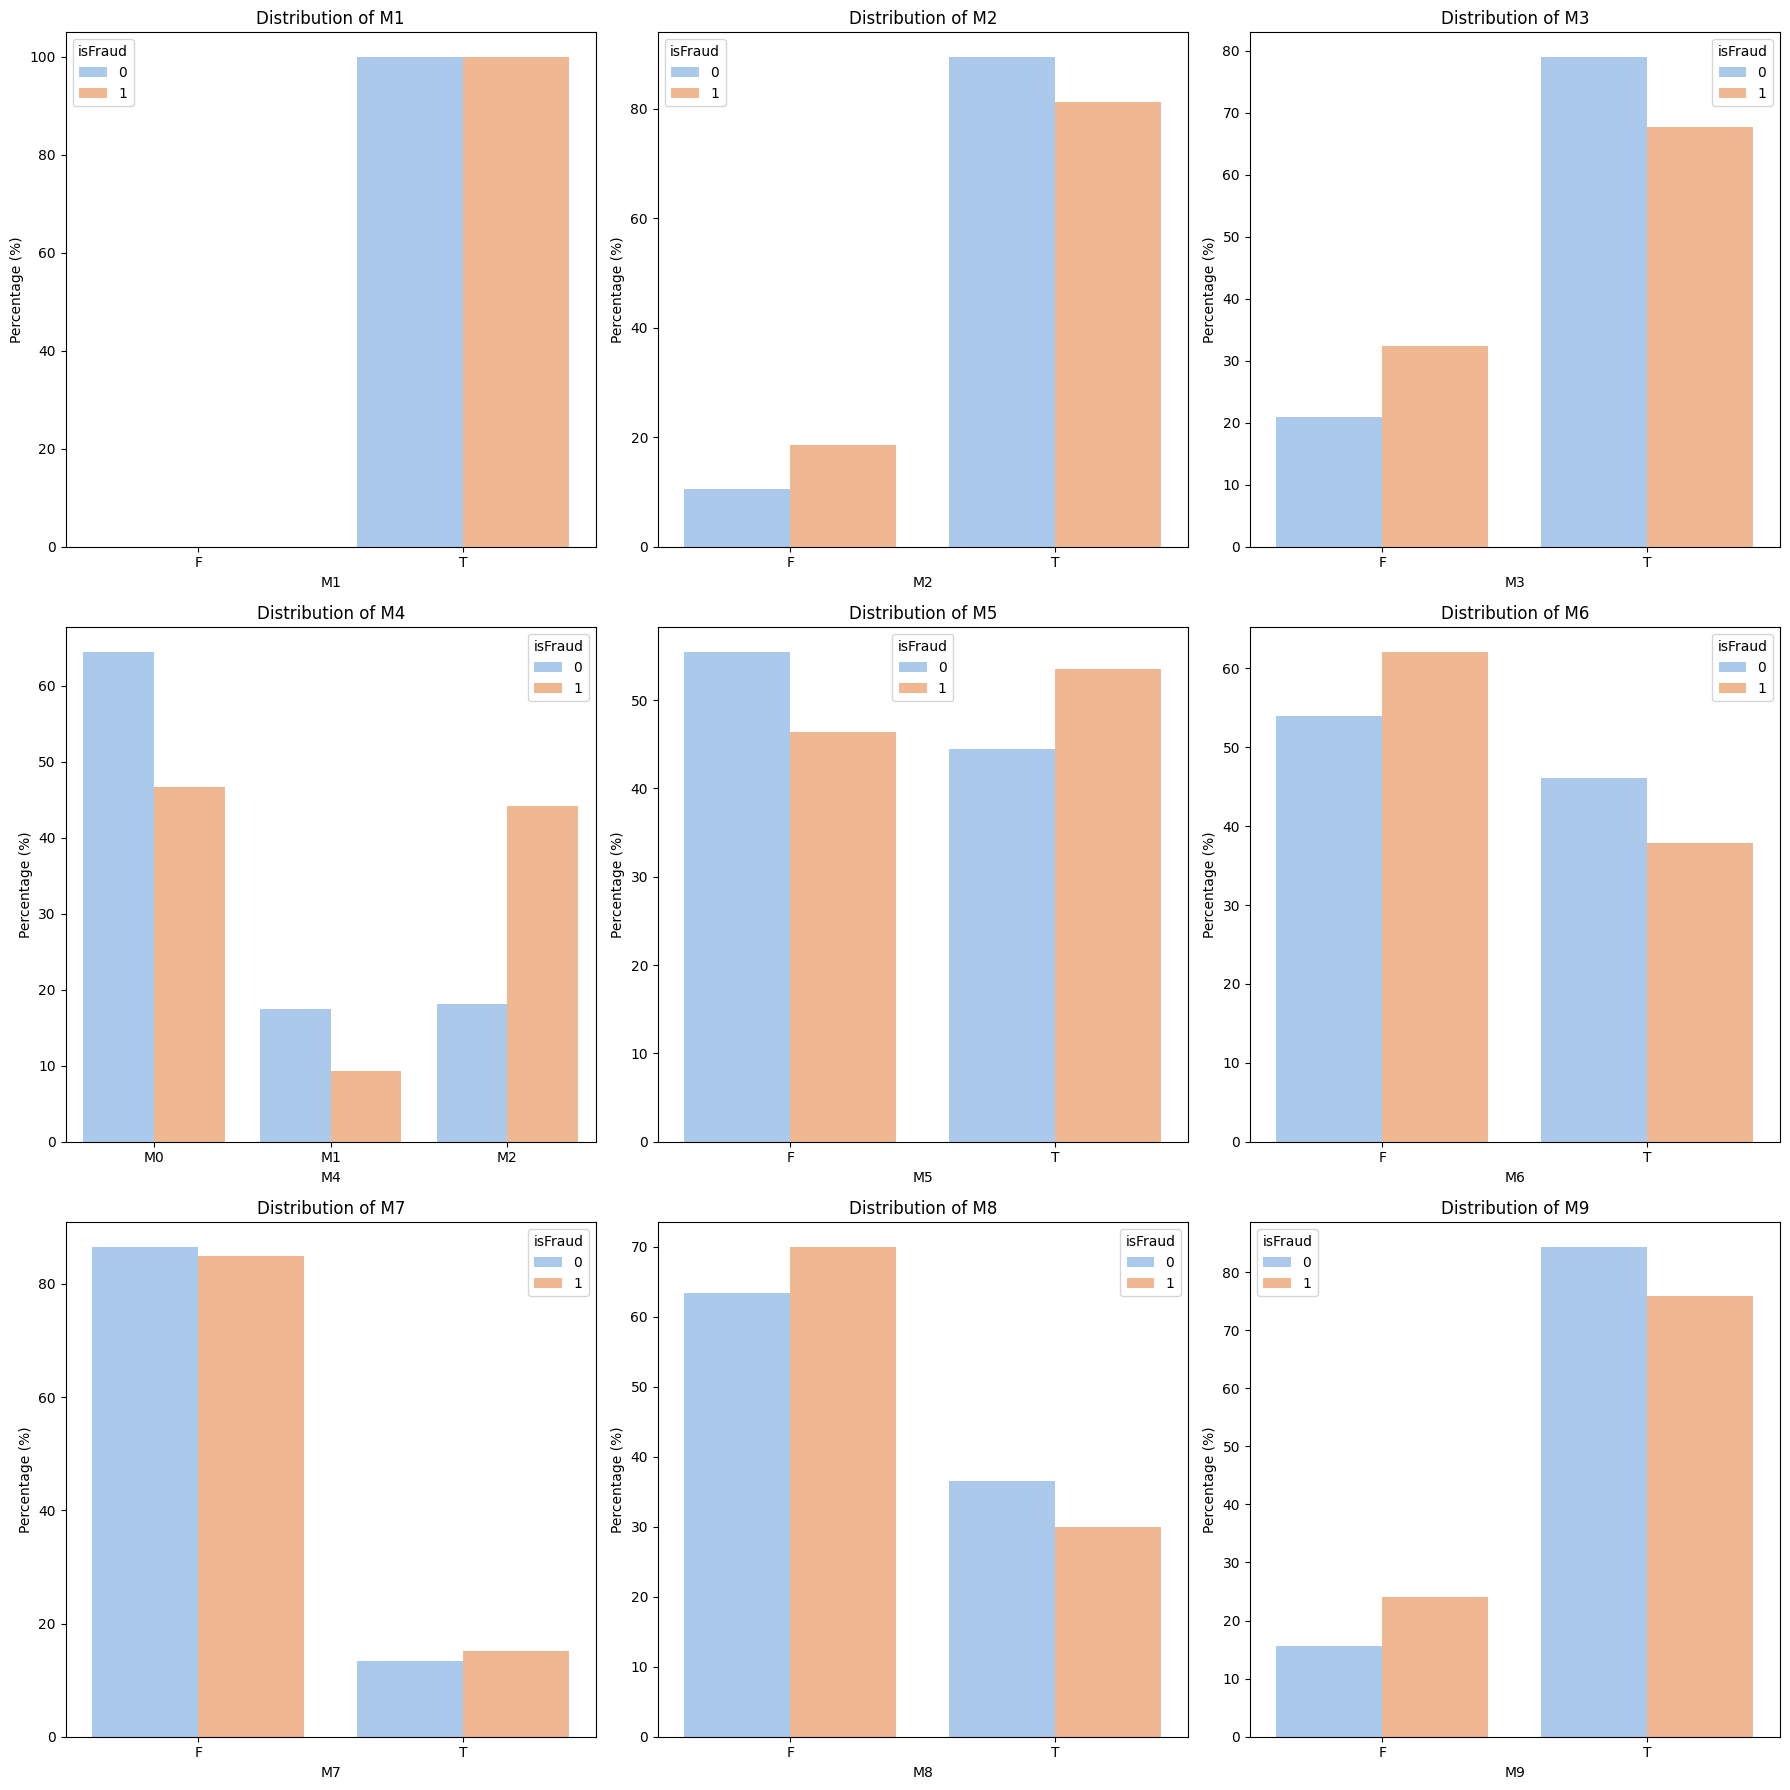

In [ ]:
plot_categorical_m_features(train)

The features M1–M9 are categorical indicators with a large portion of missing values. Since they are not numerical, we decided to encode them to allow the model to process these features effectively and capture any potential patterns.

### Id's

id01 - id 38


In [23]:
# 1328 rows without any missing values in id01-id38
print(train[~train.iloc[:, 394:432].isnull().any(axis=1)].iloc[:, 394:432].shape)
train[~train.iloc[:, 394:432].isnull().any(axis=1)].iloc[:, 394:432].head()

(1328, 38)


id_01     id_02  id_03  id_04  id_05  id_06  id_07  id_08  id_09  id_10  \
99    -10.0  129080.0    0.0    0.0    9.0  -43.0   22.0  -34.0    0.0    0.0   
188    -5.0   15464.0    0.0    0.0    4.0  -44.0    6.0  -55.0    0.0    0.0   
1702  -20.0  171610.0    0.0    0.0   13.0  -34.0    2.0  -33.0    0.0    0.0   
1706  -20.0   50100.0    0.0    0.0   12.0  -34.0    2.0  -33.0    0.0    0.0   
1714  -55.0   83328.0    0.0    0.0    9.0 -100.0   17.0  -13.0    0.0    0.0   

      id_11     id_12  id_13  id_14  id_15  id_16  id_17  id_18  id_19  id_20  \
99    100.0     Found   49.0 -300.0  Found  Found  166.0   12.0  122.0  549.0   
188   100.0     Found   55.0 -300.0  Found  Found  166.0   13.0  122.0  256.0   
1702  100.0  NotFound   15.0 -300.0  Found  Found  166.0   12.0  317.0  549.0   
1706  100.0     Found   15.0 -300.0  Found  Found  166.0   12.0  317.0  549.0   
1714  100.0  NotFound   11.0 -300.0  Found  Found  166.0   13.0  365.0  489.0   

      id_21  id_22                 id_23 id_24  id_25  id_26  id_27  id_28  \
99    252.0   14.0  IP_PROXY:TRANSPARENT  11.0  321.0  184.0  Found  Found   
188   252.0   14.0  IP_PROXY:TRANSPARENT  11.0  321.0  102.0  Found  Found   
1702  252.0   14.0  IP_PROXY:TRANSPARENT  11.0  321.0  184.0  Found  Found   
1706  252.0   14.0  IP_PROXY:TRANSPARENT  11.0  321.0  184.0  Found  Found   
1714  228.0   14.0  IP_PROXY:TRANSPARENT  11.0  426.0  117.0  Found  Found   

      id_29       id_30                  id_31 id_32      id_33  \
99    Found  iOS 11.0.3  mobile safari generic  32.0   1334x750   
188   Found     Android            chrome 62.0  32.0  2560x1440   
1702  Found  iOS 11.1.2     mobile safari 11.0  32.0  2208x1242   
1706  Found  iOS 11.1.2     mobile safari 11.0  32.0  2208x1242   
1714  Found   Windows 7    ie 11.0 for desktop  24.0   1440x900   

               id_34 id_35 id_36 id_37 id_38  
99    match_status:2     T     F     T     F  
188   match_status:2     T     F     T     T  
1702  match_status:1     T     F     T     T  
1706  match_status:1     T     F     T     T  
1714  match_status:2     T     T     T     T

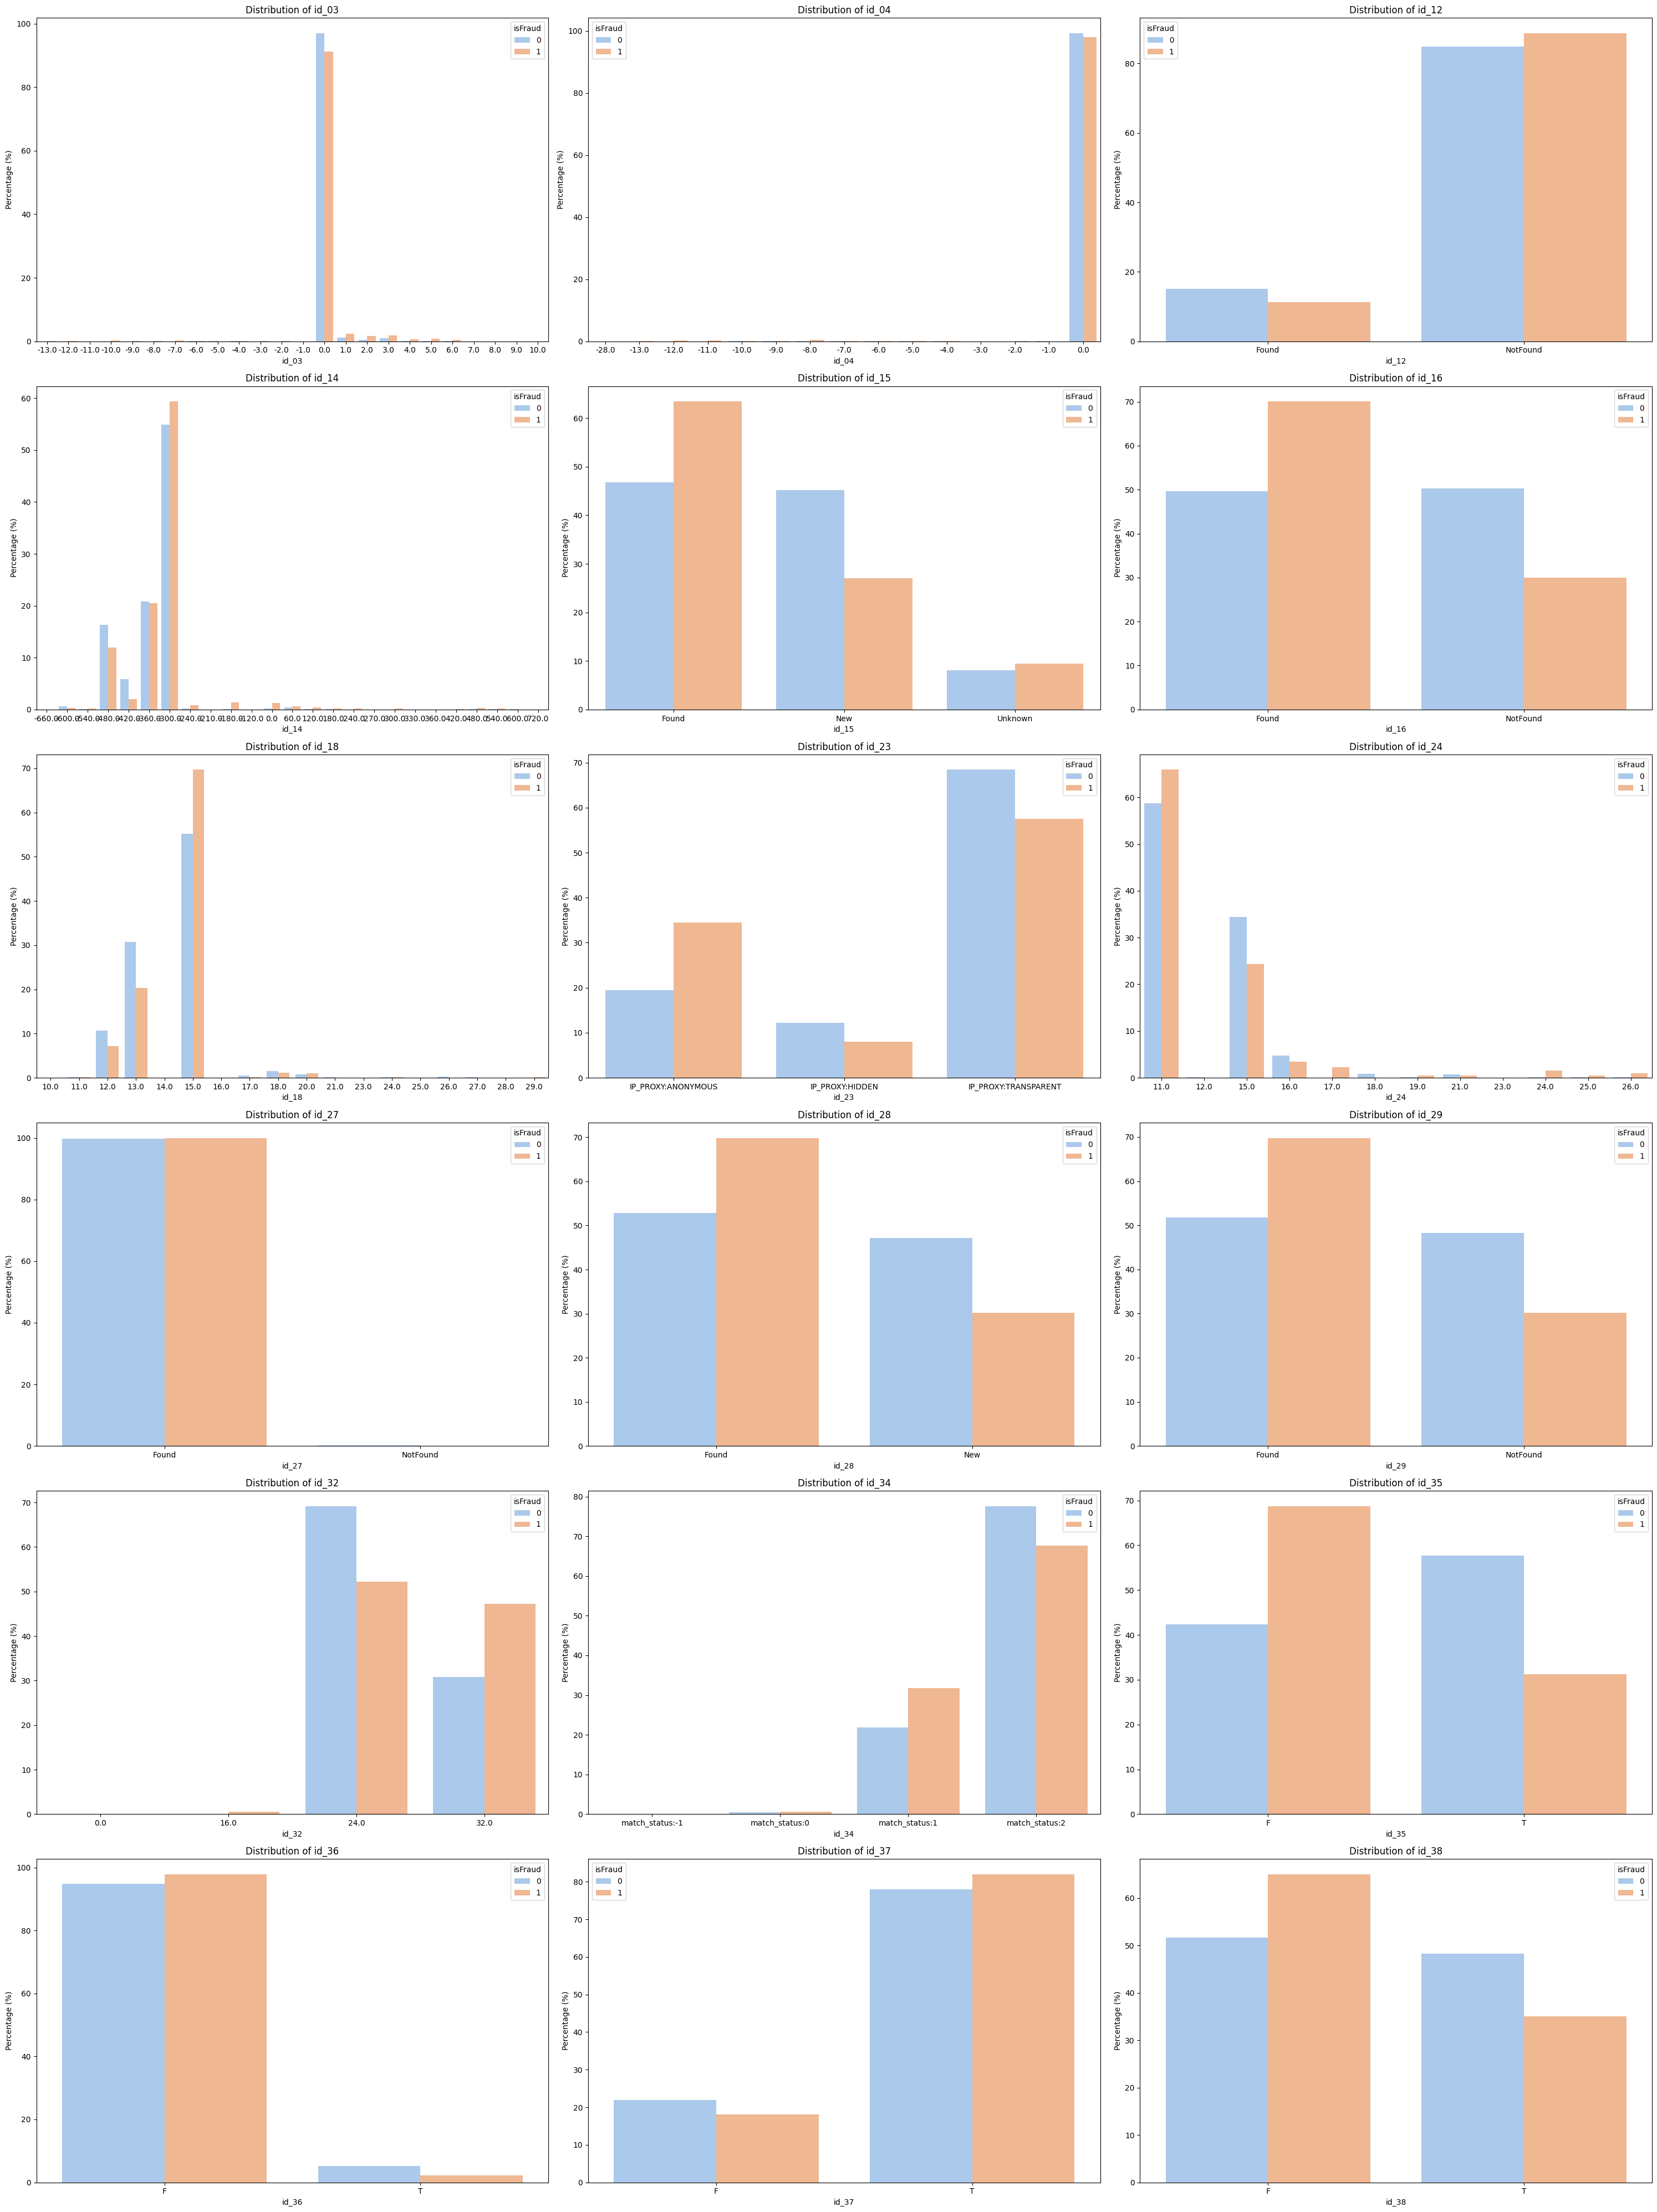

In [ ]:
plot_id_feature_distribution(train)

The features id_30 and id_31 contain information about the operating system and browser, respectively. We extracted and transformed them into two new categorical features: OS and Browser, to simplify the representation and help the model capture device-related patterns more effectively.

### DeviceType and DeviceInfo

In [ ]:
train[~train.iloc[:, 432:434].isnull().any(axis=1)].iloc[:, 432:434].head()

DeviceType                     DeviceInfo
4      mobile  SAMSUNG SM-G892A Build/NRD90M
8      mobile                     iOS Device
10    desktop                        Windows
16    desktop                          MacOS
17    desktop                        Windows

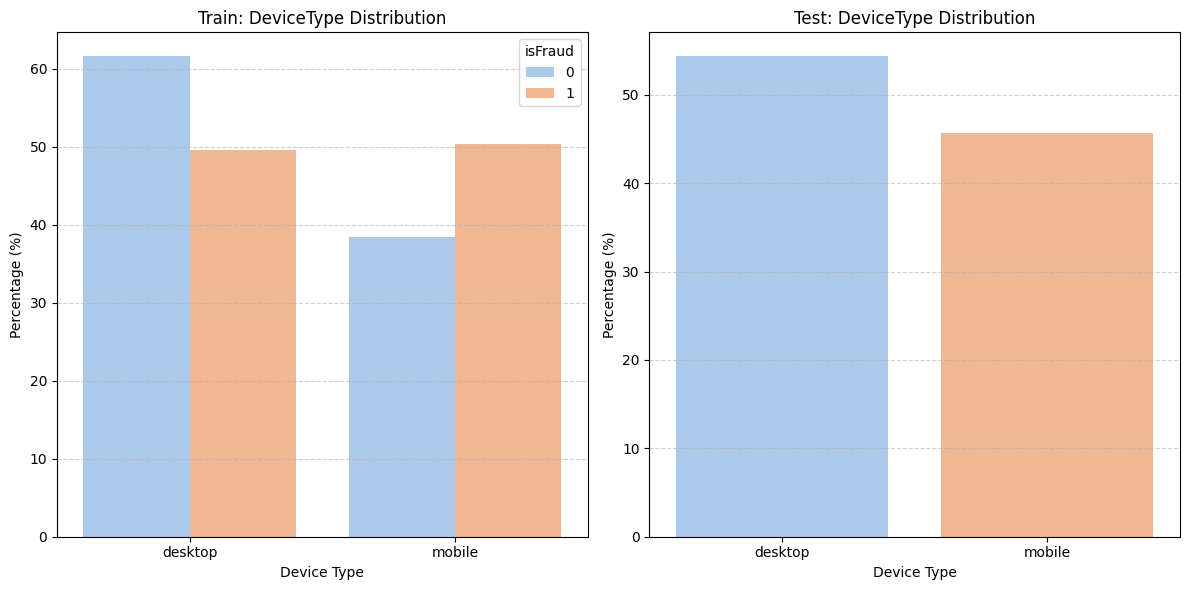

In [ ]:
plot_device_type_distribution(train, test)


From the DeviceInfo feature, I extracted the device manufacturer (e.g., Apple, Samsung) to create a new feature representing the corporate origin of the device. This helps the model identify patterns related to the type of device used in transactions.

Both Desktop and mobile have the same percentage of fraud.

### Vxxx And Correlation Analysis

To identify features that may have predictive power, we will look at the correlation between numerical features and the target variable, isFraud. This will help us focus our feature engineering efforts.

In [ ]:
# Correlation between numerical features and isFraud
corr_matrix = train_transaction.select_dtypes(include=[np.number]).corr()
fraud_corr = corr_matrix['isFraud'].sort_values(ascending=False)
# Filter top correlated features
top_corr_features = fraud_corr[abs(fraud_corr) > 0.1]
# Display top correlated features with isFraud
print("Top correlated features with isFraud:")
print(top_corr_features.head(20))

Top correlated features with isFraud:
isFraud    1.000000
V257       0.383060
V246       0.366878
V244       0.364129
V242       0.360590
V201       0.328005
V200       0.318783
V189       0.308219
V188       0.303582
V258       0.297151
V45        0.281832
V158       0.278066
V156       0.275952
V149       0.273282
V228       0.268861
V44        0.260376
V86        0.251828
V87        0.251737
V170       0.249794
V147       0.242894
Name: isFraud, dtype: float64


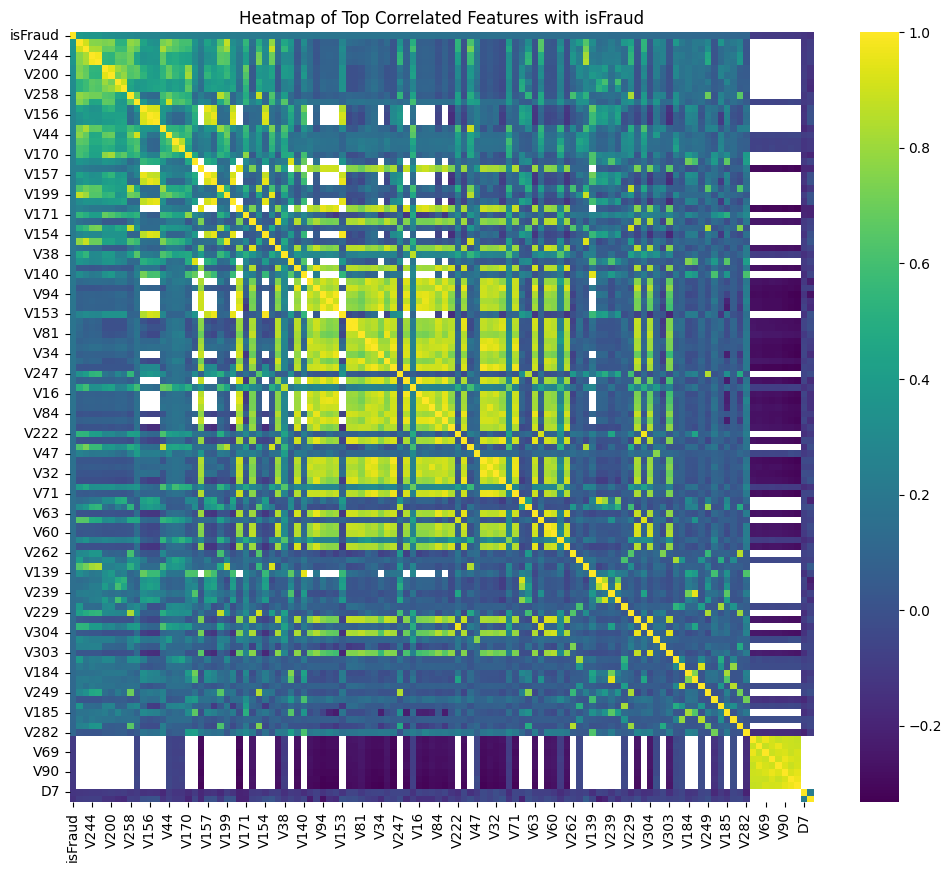

In [ ]:
# Heatmap of top correlated features
plt.figure(figsize=(12, 10))
sns.heatmap(train_transaction[top_corr_features.index].corr(), cmap='viridis', annot=False, cbar=True)
plt.title('Heatmap of Top Correlated Features with isFraud')
plt.show()

The correlation analysis reveals that many of the V features have moderate positive correlations with isFraud, suggesting they capture key fraud patterns. High-correlation clusters in the heatmap indicate redundancy, offering opportunities for dimensionality reduction and regularization to improve model performance. Transactional metadata like TransactionAmt shows low correlation with isFraud, implying that transformations and interaction features will be needed to enhance its predictive value